# Análisis de retención de clientes - "Model Fitness"
## Descripción del proyecto:
La cadena de gimnasios Model Fitness está desarrollando una estrategia de interacción con clientes basada en datos analíticos.

Uno de los problemas más comunes que enfrentan los gimnasios y otros servicios es la pérdida de clientes. ¿Cómo descubres si un/a cliente ya no está contigo? Puedes calcular la pérdida en función de las personas que se deshacen de sus cuentas o no renuevan sus contratos. Sin embargo, a veces no es obvio que un/a cliente se haya ido: puede que se vaya de puntillas.

Los indicadores de pérdida varían de un campo a otro. Si un usuario o una usuaria compra en una tienda en línea con poca frecuencia, pero con regularidad, no se puede decir que ha huido. Pero si durante dos semanas no ha abierto un canal que se actualiza a diario, es motivo de preocupación: es posible que tu seguidor o seguidor/a se haya aburrido y te haya abandonado.

En el caso de un gimnasio, tiene sentido decir que un/a cliente se ha ido si no viene durante un mes. Por supuesto, es posible que estén en Cancún y retomen sus visitas cuando regresen, pero ese no es un caso típico. Por lo general, si un/a cliente se une, viene varias veces y luego desaparece, es poco probable que regrese.

Con el fin de combatir la cancelación, Model Fitness ha digitalizado varios de sus perfiles de clientes. Tu tarea consiste en analizarlos y elaborar una estrategia de retención de clientes.

Se debe:


- Aprender a predecir la probabilidad de pérdida (para el próximo mes) para cada cliente.
- Elaborar retratos de usuarios típicos: selecciona los grupos más destacados y describe sus características principales.
- Analizar los factores que más impactan la pérdida.
- Sacar conclusiones básicas y elaborar recomendaciones para mejorar la atención al cliente:
    - identificar a los grupos objetivo;
    - sugerir medidas para reducir la rotación;
    - describir cualquier otro patrón que observes con respecto a la interacción con los clientes.

## 1. Configuración inicial y carga de datos:

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Configuración para mejores visualizaciones

#plt.style.use('seaborn-v0_8')
#sns.set_palette("husl")
#%matplotlib inline

In [3]:
# Descargar los datos
gym_df = pd.read_csv('../data/raw/gym_churn_us.csv')

## 2. Análisis exploratorio de datos (EDA):
### 2.1 Observar el dataset: Estudiar valores promedio y desviación estándar.

In [4]:

# Mostrar información básica
print("Describe:\n",gym_df.describe(include='all'))
print("\n")
print("Info:\n")
print(gym_df.info())
display(gym_df.sample(10))


Describe:
             gender  Near_Location      Partner  Promo_friends        Phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       Contract_period  Group_visits          Age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.00000

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
3183,1,1,0,1,1,1,1,30,66.311322,1.0,1,2.503144,2.426164,0
371,0,1,0,0,1,1,0,25,118.020289,1.0,1,0.715105,0.423586,1
2081,0,0,0,0,1,1,0,32,93.014206,1.0,4,1.249033,1.000031,0
3622,1,1,0,0,1,1,0,26,153.260154,1.0,1,1.848847,2.263137,1
1197,1,1,1,1,0,12,0,28,64.695144,12.0,8,0.000000,0.073276,0
3515,0,1,0,0,1,1,0,27,187.041065,1.0,4,2.147104,2.299364,0
1925,0,1,0,0,1,6,0,35,72.623348,6.0,1,0.964873,0.958706,0
3486,0,1,1,0,1,12,1,31,49.684406,12.0,7,2.741202,2.758926,0
2776,1,1,1,0,1,1,0,20,168.743934,1.0,1,0.603979,0.000000,1
2015,1,0,0,0,1,1,0,31,16.854518,1.0,4,4.218271,4.327701,0


In [5]:
# Checar valores ausentes
print("Valores ausentes por columna:\n")
missing_values = gym_df.isnull().sum()
missing_percent = (gym_df.isnull().sum() / len(gym_df)) * 100
missing_info = pd.DataFrame({
    'Missing_Values': missing_values,
    'Missing_Percentage': missing_percent.round(2)
})
# Mostrar solo columnas con valores ausentes (si las hay)
if missing_values.sum() == 0:
    print("No hay valores ausentes en el dataset")
else:
    display(missing_info[missing_info['Missing_Values'] > 0])

Valores ausentes por columna:

No hay valores ausentes en el dataset


In [6]:
# Checar distribución de variables binarias/categóricas
#print("Distribución de variables binarias/categóricas:")
#binary_vars = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits', 'Churn']
#for var in binary_vars:
#    print(f"\n{var}:")
#    print(gym_df[var].value_counts())
#    print(f"Proporción de 1s: {gym_df[var].mean():.2%}")

**Observaciones:**
- No se encuentran características ausentes en el dataset.

- Respecto a los valores promedio y desviación estándar: 

    - 'gender': Media: 0.5102, Desviación estándar: 0.4999; muestra balanceada.
    - 'Near_Location': Media: 0.8452, Desviación estándar: 0.3617; un 84.5% de la muestra vive cerca.
    - 'Partner': Media: 0.4867, Desviación estándar: 0.4998; muestra equilibrada.
    - 'Promo_friends' Media: 0.3085, Desviación estándar: 0.4619; un 30% vino por recomendación (quizás no sea tan efectivo).
    - 'Phone': Media: 0.9035, Desviación estándar: 0.2953; alta dispocición a contacto por teléfono.
    - 'Contract_period': Media: 4.6812, Desviación estándar: 4.5497; indica una variabilidad alta en contratos.
    - 'Group_visits': Media: 0.4122, Desviación estándar: 0.4923; 41.2% hacen clases en grupos.
    - 'Age': Media: 29.1842, Desviación estándar: 3.258; clientes jóvenes.
    - 'Avg_additional_charges_total': Media 146.9437, Desviación estándar: 96.3556; gastos bastante variables.
    - 'Month_to_end_contract: Media 4.3227, Desviación estándar:  4.1912; varios contratos cerca del vencimiento.
    - 'Lifetime': Media: 3.7247, Desviación estándar: 3.7492; en su mayoría son clientes reltivamente nuevos.
    - 'Avg_class_frequency_total': Media: 1.8790, Desviación estándar: 0.9722; históricamente los clientes van 2 veces por semana.
    - 'Avg_class_frequency_month': Media: 1.7670, Desviación estándar: 1.0529; en el mes actual, bajó muy poco la afluencia de clientes.
    - 'Churn': Media: 0.2652, Desviación estándar: 0.4415; indica un aspecto a mejorar, ya que el 25% de clientes se va (1 de cada 4).

### 2.2 Observar valores medios de las características en dos grupos: para personas que se fueron (cancelación) y para las que se quedaron.

In [7]:
# Calcular medias por grupo de churn
print("Medias por grupos de 'Churn':\n")
churn_means = gym_df.groupby('Churn').mean()
display(churn_means)
print("\n")

# Calcular diferencia absoluta entre grupos
no_churn = churn_means.loc[0]  # Clientes que NO cancelaron
yes_churn = churn_means.loc[1]  # Clientes que SÍ cancelaron
difference = (yes_churn - no_churn).abs()

print("\nDiferencias absolutas entre grupos:")
diff_df = pd.DataFrame({
    'No_Churn (0)': no_churn,
    'Churn (1)': yes_churn, 
    'Diferencia': difference
}).round(4)
display(diff_df)

# Ordenar por mayores diferencias
print("\nCaracterísticas con mayor diferencia entre grupos:\n")
top_differences = diff_df['Diferencia'].sort_values(ascending=False)
display(top_differences)

Medias por grupos de 'Churn':



,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546





Diferencias absolutas entre grupos:


,No_Churn (0),Churn (1),Diferencia
gender,0.5100,0.5108,0.0008
Near_Location,0.8731,0.7681,0.1049
Partner,0.5342,0.3553,0.1789
Promo_friends,0.3535,0.1838,0.1697
Phone,0.9037,0.9029,0.0008
Contract_period,5.7472,1.7286,4.0186
Group_visits,0.4641,0.2686,0.1955
Age,29.9765,26.9896,2.9869
Avg_additional_charges_total,158.4457,115.0829,43.3628
Month_to_end_contract,5.2831,1.6626,3.6205



Características con mayor diferencia entre grupos:



Avg_additional_charges_total         43.3628
Contract_period                       4.0186
Lifetime                              3.7212
Month_to_end_contract                 3.6205
Age                                   2.9869
Avg_class_frequency_current_month     0.9833
Avg_class_frequency_total             0.5499
Group_visits                          0.1955
Partner                               0.1789
Promo_friends                         0.1697
Near_Location                         0.1049
Phone                                 0.0008
gender                                0.0008
Name: Diferencia, dtype: float64

### 2.3 Trazar histogramas de barras y distribuciones de características para personas que se fueron (cancelación) y para las que se quedaron.

In [8]:
# Separar los datos
churn_0 = gym_df[gym_df['Churn'] == 0]  # NO cancelaron
churn_1 = gym_df[gym_df['Churn'] == 1]  # SÍ cancelaron

# Definir variables por tipo (todas las columnas excepto Churn)

all_columns = gym_df.columns.drop('Churn')
binary_vars = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits']

numeric_vars = [col for col in all_columns if col not in binary_vars]

print(f"Variables binarias: {len(binary_vars)}")
print(f"Variables numéricas: {len(numeric_vars)}")
print(f"Total de características a analizar: {len(all_columns)}")

Variables binarias: 6
Variables numéricas: 7
Total de características a analizar: 13


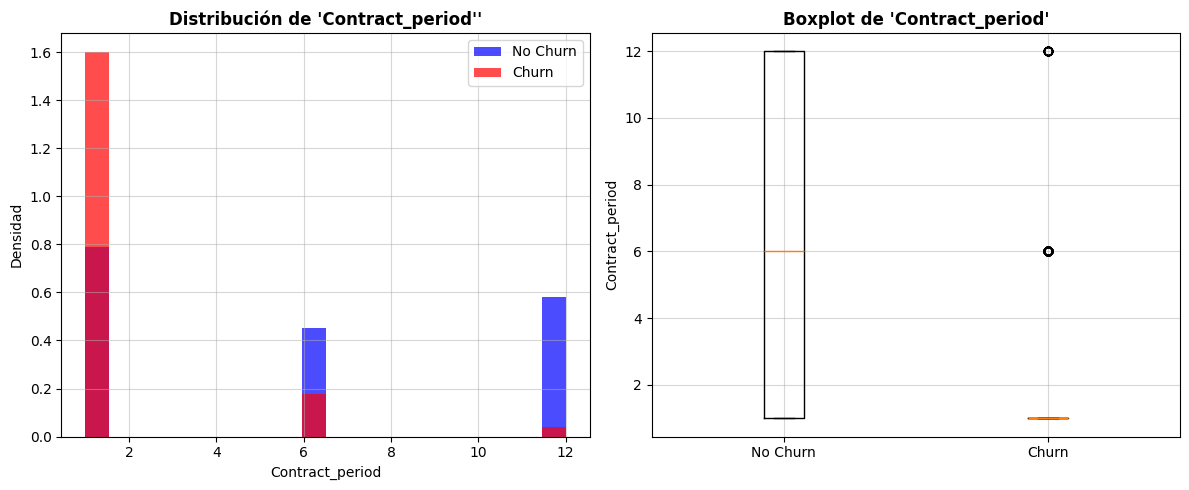

'Contract_period':
- No Churn: 5.7472 | Churn: 1.7286
- Diferencia absoluta: +4.02
- Diferencia relativa: +232.48%
Conjetura: Los clientes leales tienen en promedio 4.02 unidades más en 'Contract_period'
--------------------------------------------------------------------------------------------------------------------------------------------


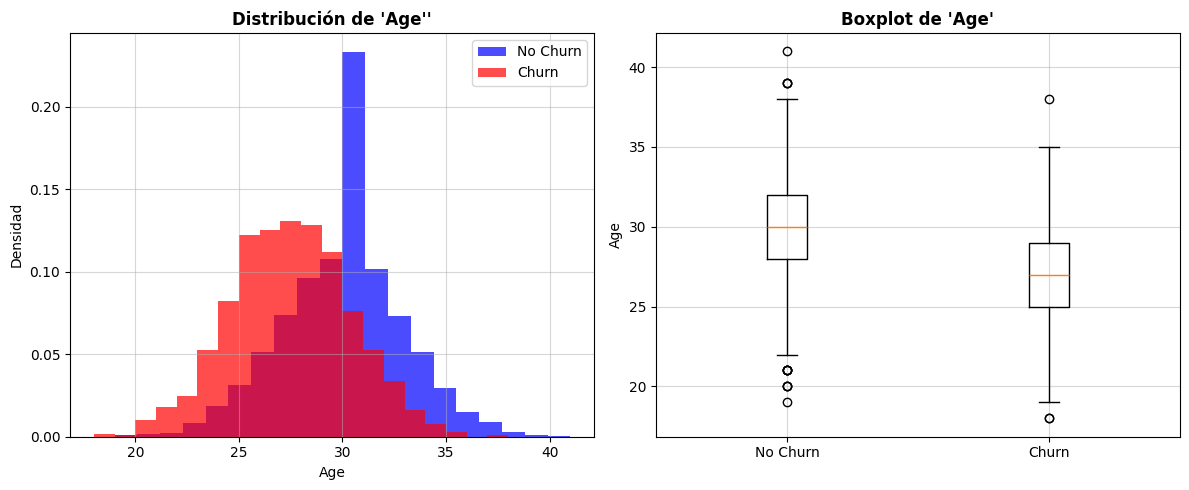

'Age':
- No Churn: 29.9765 | Churn: 26.9896
- Diferencia absoluta: +2.99
- Diferencia relativa: +11.07%
Conjetura: Los clientes leales tienen en promedio 2.99 unidades más en 'Age'
--------------------------------------------------------------------------------------------------------------------------------------------


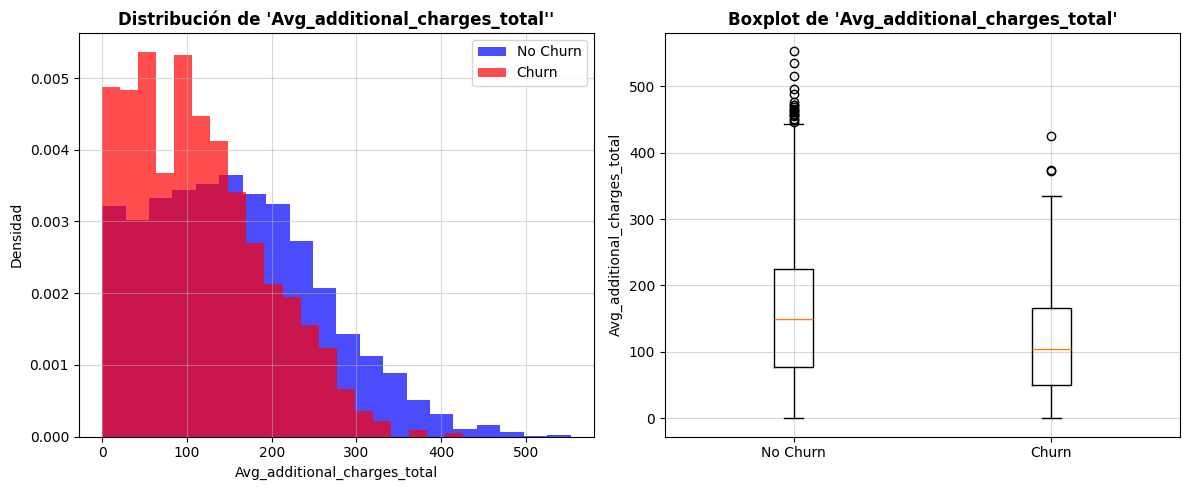

'Avg_additional_charges_total':
- No Churn: 158.4457 | Churn: 115.0829
- Diferencia absoluta: +43.36
- Diferencia relativa: +37.68%
Conjetura: Los clientes leales tienen en promedio 43.36 unidades más en 'Avg_additional_charges_total'
--------------------------------------------------------------------------------------------------------------------------------------------


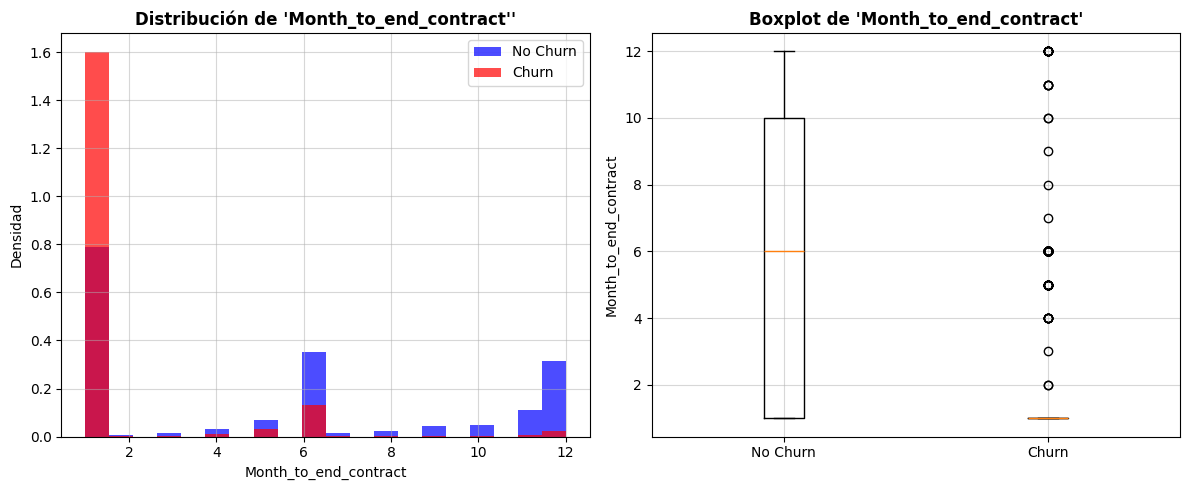

'Month_to_end_contract':
- No Churn: 5.2831 | Churn: 1.6626
- Diferencia absoluta: +3.62
- Diferencia relativa: +217.76%
Conjetura: Los clientes leales tienen en promedio 3.62 unidades más en 'Month_to_end_contract'
--------------------------------------------------------------------------------------------------------------------------------------------


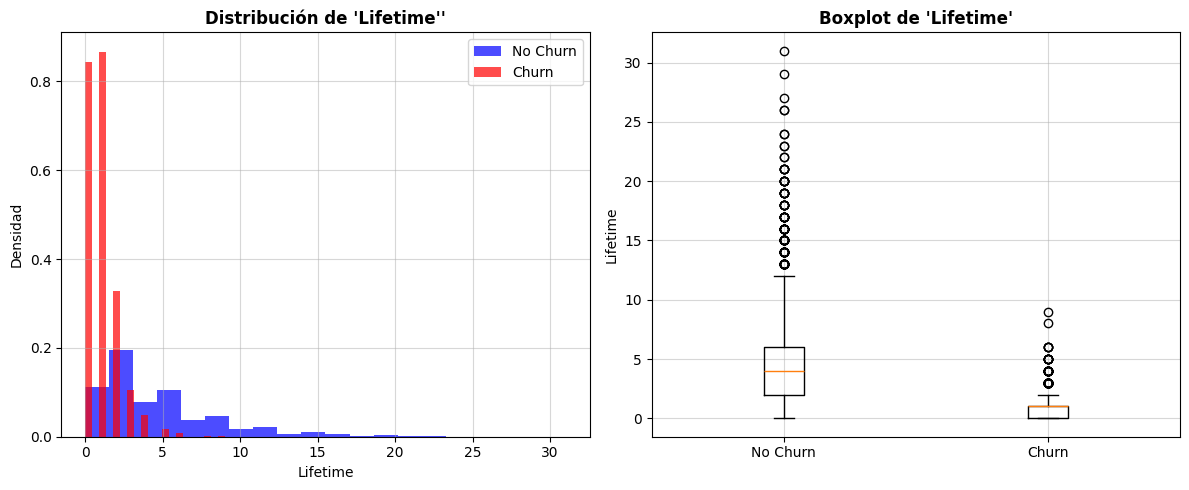

'Lifetime':
- No Churn: 4.7118 | Churn: 0.9906
- Diferencia absoluta: +3.72
- Diferencia relativa: +375.66%
Conjetura: Los clientes leales tienen en promedio 3.72 unidades más en 'Lifetime'
--------------------------------------------------------------------------------------------------------------------------------------------


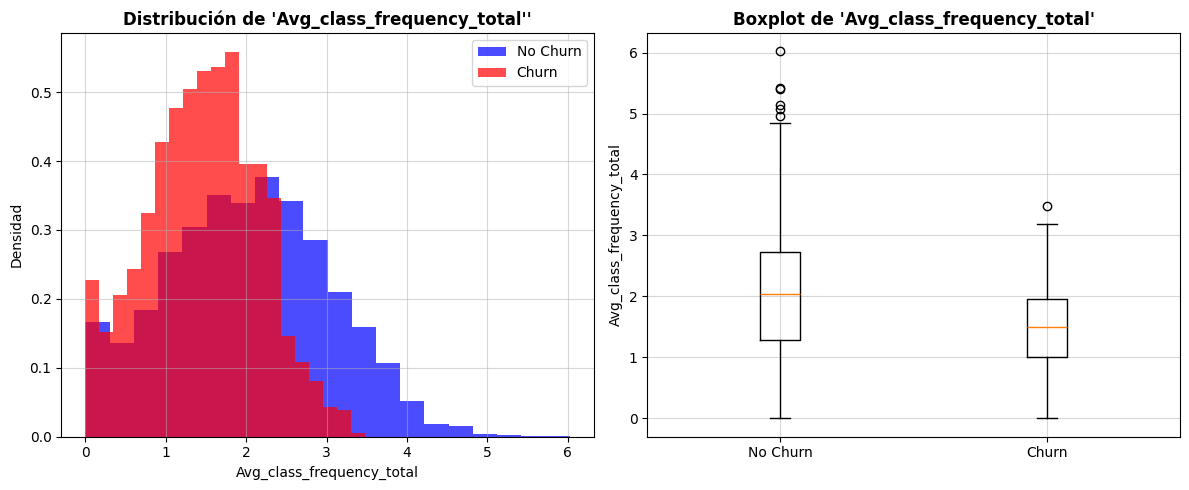

'Avg_class_frequency_total':
- No Churn: 2.0249 | Churn: 1.4750
- Diferencia absoluta: +0.55
- Diferencia relativa: +37.28%
Conjetura: Los clientes leales tienen en promedio 0.55 unidades más en 'Avg_class_frequency_total'
--------------------------------------------------------------------------------------------------------------------------------------------


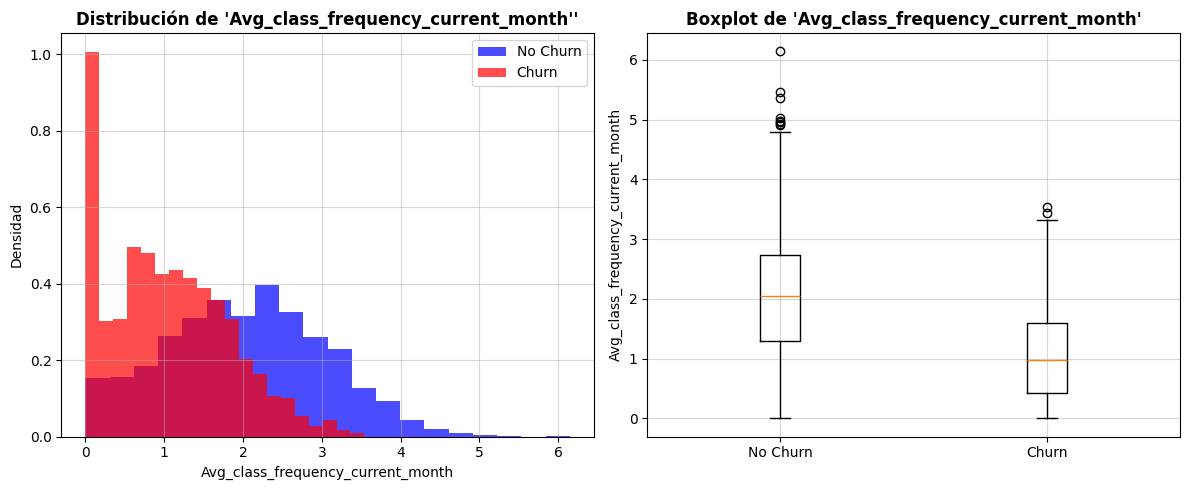

'Avg_class_frequency_current_month':
- No Churn: 2.0279 | Churn: 1.0445
- Diferencia absoluta: +0.98
- Diferencia relativa: +94.14%
Conjetura: Los clientes leales tienen en promedio 0.98 unidades más en 'Avg_class_frequency_current_month'
--------------------------------------------------------------------------------------------------------------------------------------------


In [9]:
# Histogramas y boxplots para variables numéricas
for i, variable in enumerate(numeric_vars):  # Todas las variables numéricas
    plt.figure(figsize=(12, 5))
    
    # Subplot 1: Histograma
    plt.subplot(1, 2, 1)
    plt.hist(churn_0[variable], alpha=0.7, label='No Churn', bins=20, color='blue', density=True)
    plt.hist(churn_1[variable], alpha=0.7, label='Churn', bins=20, color='red', density=True)
    plt.title(f"Distribución de '{variable}''", fontweight='bold')
    plt.xlabel(variable)
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True, alpha=0.5)
    
    # Subplot 2: Boxplot
    plt.subplot(1, 2, 2)
    data = [churn_0[variable], churn_1[variable]]
    plt.boxplot(data, labels=['No Churn', 'Churn'])
    plt.title(f"Boxplot de '{variable}'", fontweight='bold')
    plt.ylabel(variable)
    plt.grid(True, alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Conclusiones breves
    mean_0 = churn_0[variable].mean()
    mean_1 = churn_1[variable].mean()
    diff = mean_0 - mean_1
    diff_pct = (diff / mean_1) * 100 if mean_1 != 0 else 0
    
    # Calcular diferencia porcentual relativa
    if mean_0 > mean_1:
        rel_diff = ((mean_0 - mean_1) / mean_1) * 100
    else:
        rel_diff = ((mean_1 - mean_0) / mean_0) * 100
    
    print(f"'{variable}':")
    print(f"- No Churn: {mean_0:.4f} | Churn: {mean_1:.4f}")
    print(f"- Diferencia absoluta: {diff:+.2f}")
    print(f"- Diferencia relativa: {rel_diff:+.2f}%")
    
    # Interpretación contextual
   
    if diff > 0:
        print(f"Conjetura: Los clientes leales tienen en promedio {diff:.2f} unidades más en '{variable}'")
    else:
        print(f"Conjetura: Los clientes que cancelan tienen en promedio {abs(diff):.2f} unidades más en '{variable}'")

    print("-" * 140)


**Observaciones:** 
- 'Contract_period': - Los clientes leales tienen contratos más largos (5.7 meses) que los que cancelan (1.7 meses).

- 'Age':  - Ambos grupos están concentrados entre 25-35 años, pero los clientes leales son ligeramente mayores (30 años) comparados con los que cancelan (27 años). 

- 'Avg_additional_charges_total': - Los clientes leales muestran gastos más altos (158), mientras los que cancelan gastan menos (115). El gasto adicional parece ser importante para la retención.

- 'Month_to_end_contract': - Los clientes leales cuentan con 5.3 meses restantes; los que cancelan cuentan con 1.7. Para predecir la cancelación parece ser una variable imprescindible. 

- 'Lifetime': - Clientes leales tienen 4.7  meses de antigüedad mientras que los que cancelan sólo 1 mes. La mayoría de los clientes que cancela son muy nuevos (menos de 3 meses), lo que sugiere ser un factor imprescindible. 

- 'Avg_class_frequency_current_month': - Los clientes leales visitan en promedio 2.03 veces por semana, mientras los que cancelan van 1.04 veces. La frecuencia de visitas puede ser un predictor imprescindible.

- 'Avg_class_frequency_total': - Los clientes leales van 2.02 veces por semana; los que cancelan 1.47. 

NOTA:
Valores 1 = Sí tiene la característica
Valores 0 = No tiene la característica
Cuando se dice "10% más de valores 1", significa "10% más de clientes que SÍ tienen esa característica"



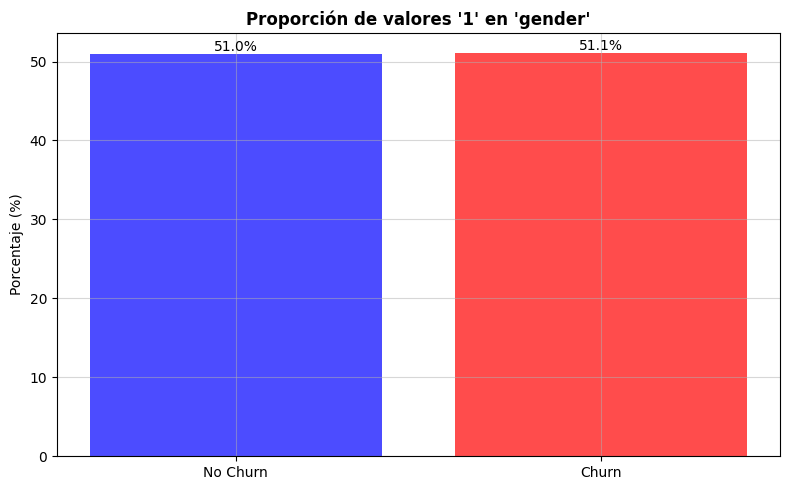

'gender':
- No Churn: '51.0'% de 1s | Churn: 51.1% de 1s
- Diferencia: '-0.1'%
Conjetura: Hay 0.1% más de valores 1, entre clientes que cancelan.
--------------------------------------------------------------------------------------------------------------------------------------------


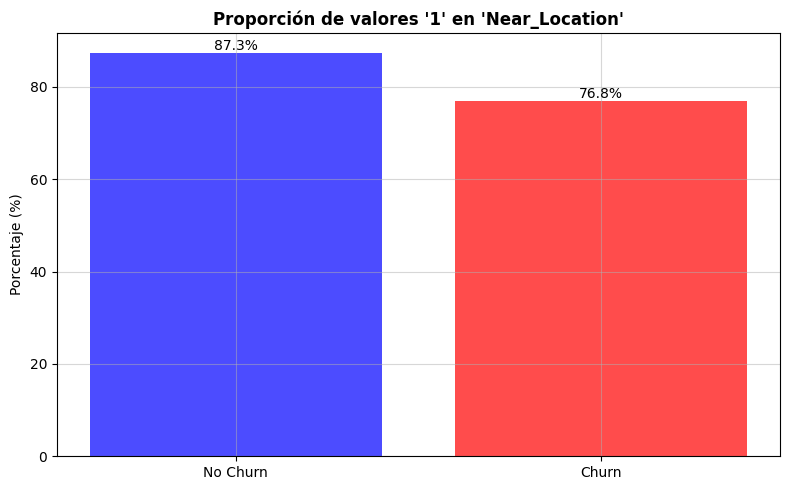

'Near_Location':
- No Churn: '87.3'% de 1s | Churn: 76.8% de 1s
- Diferencia: '+10.5'%
Conjetura: Hay 10.5% más de valores 1, entre clientes leales.
--------------------------------------------------------------------------------------------------------------------------------------------


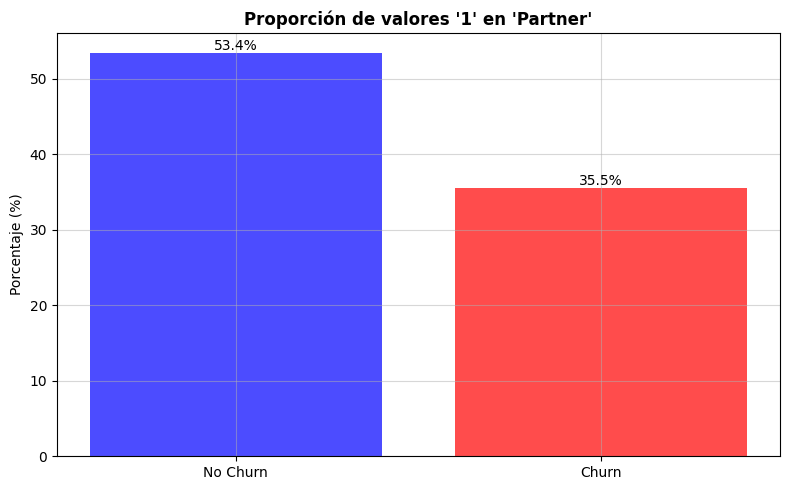

'Partner':
- No Churn: '53.4'% de 1s | Churn: 35.5% de 1s
- Diferencia: '+17.9'%
Conjetura: Hay 17.9% más de valores 1, entre clientes leales.
--------------------------------------------------------------------------------------------------------------------------------------------


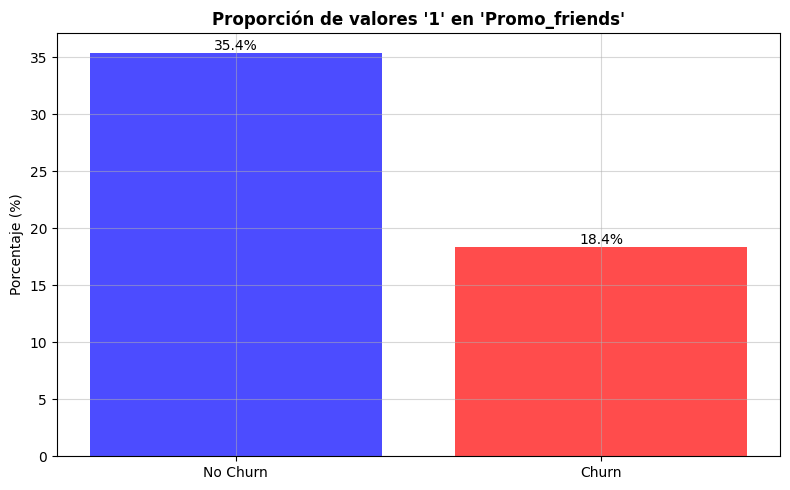

'Promo_friends':
- No Churn: '35.4'% de 1s | Churn: 18.4% de 1s
- Diferencia: '+17.0'%
Conjetura: Hay 17.0% más de valores 1, entre clientes leales.
--------------------------------------------------------------------------------------------------------------------------------------------


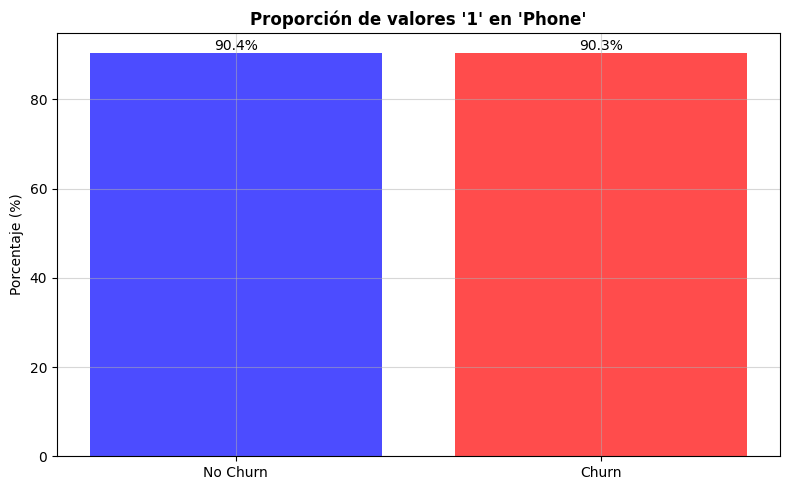

'Phone':
- No Churn: '90.4'% de 1s | Churn: 90.3% de 1s
- Diferencia: '+0.1'%
Conjetura: Hay 0.1% más de valores 1, entre clientes leales.
--------------------------------------------------------------------------------------------------------------------------------------------


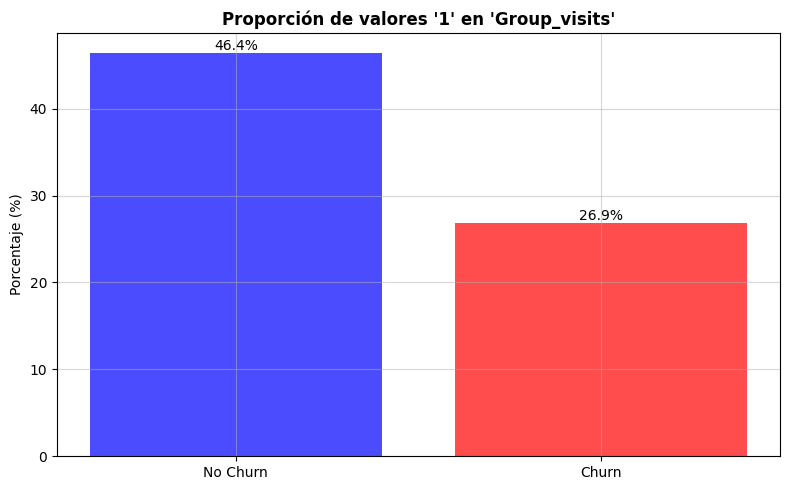

'Group_visits':
- No Churn: '46.4'% de 1s | Churn: 26.9% de 1s
- Diferencia: '+19.5'%
Conjetura: Hay 19.5% más de valores 1, entre clientes leales.
--------------------------------------------------------------------------------------------------------------------------------------------


In [10]:
# Gráficos de barras para variables binarias
print("NOTA:")
print("Valores 1 = Sí tiene la característica")
print("Valores 0 = No tiene la característica")
print('Cuando se dice "10% más de valores 1", significa "10% más de clientes que SÍ tienen esa característica"\n')

for variable in binary_vars:
    # Calcular proporciones
    prop_0 = churn_0[variable].mean() * 100  # % de 1s en No Churn
    prop_1 = churn_1[variable].mean() * 100  # % de 1s en Churn
    diff = prop_0 - prop_1
    
    plt.figure(figsize=(8, 5))
    
    # Gráfica de barras simple
    plt.bar(['No Churn', 'Churn'], [prop_0, prop_1], color=['blue', 'red'], alpha=0.7)
    plt.title(f"Proporción de valores '1' en '{variable}'", fontweight='bold')
    plt.ylabel("Porcentaje (%)")
    plt.grid(True, alpha=0.5)
    
    # Añadir valores en las barras
    for i, v in enumerate([prop_0, prop_1]):
        plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print(f"'{variable}':")
    print(f"- No Churn: '{prop_0:.1f}'% de 1s | Churn: {prop_1:.1f}% de 1s")
    print(f"- Diferencia: '{diff:+.1f}'%")
    
    if diff > 0:
        print(f"Conjetura: Hay {diff:.1f}% más de valores 1, entre clientes leales.")
    else:
        print(f"Conjetura: Hay {abs(diff):.1f}% más de valores 1, entre clientes que cancelan.")
    
    print("-" * 140)

**Observaciones:**
- 'gender': - La distribución de género es casi idéntica (51.0% vs 51.1%). 

- 'Near_Location': - Los clientes leales muestran mayor proporción de vivir cerca del gimnasio (87.3%) comparado con los que cancelan (76.8%). El vivir cerca parece favorecer la retención.

- 'Partner': - Los clientes leales muestran una mayor proporción de ser empleados de empresas asociadas (53.4%) que los que cancelan (35.5%). Ser un empleado asociado parece favorecer la retención.

- 'Group_visits': - Los clientes leales tienen mayor participación en clases grupales (46.4%); los que cancelan no tanto (26.9%). La participación en actividades grupales parece fortalecer la lealtad.

- 'Phone': - La proporción de clientes que proporcionaron su teléfono es casi idéntica (90.4% vs 90.3%). 

- 'Promo_friends': - Los clientes leales tienen mayor proporción de haber llegado por recomendación (35.4%), mientras los que cancelan son muy pocos(18.4%). Los clientes por referidos muestran tener una mayor retención.

### 2.4 Crear matriz de correlación.

In [11]:
# Calcular matriz de correlación
correlation_matrix = gym_df.corr()
display(correlation_matrix.round(4))

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
gender,1.0000,0.0067,-0.0105,-0.0050,-0.0085,0.0005,0.0179,0.0138,-0.0093,-0.0013,0.0136,0.0146,0.0092,0.0007
Near_Location,0.0067,1.0000,-0.0051,0.2110,-0.0158,0.1502,0.1547,0.0584,0.0408,0.1440,0.0709,0.0431,0.0627,-0.1281
Partner,-0.0105,-0.0051,1.0000,0.4520,0.0100,0.3062,0.0227,0.0475,0.0229,0.2946,0.0612,0.0249,0.0456,-0.1580
Promo_friends,-0.0050,0.2110,0.4520,1.0000,0.0020,0.2446,0.1202,0.0501,0.0369,0.2396,0.0727,0.0281,0.0538,-0.1622
Phone,-0.0085,-0.0158,0.0100,0.0020,1.0000,-0.0069,-0.0101,-0.0114,0.0093,-0.0112,-0.0188,0.0083,0.0134,-0.0012
Contract_period,0.0005,0.1502,0.3062,0.2446,-0.0069,1.0000,0.1700,0.1382,0.1114,0.9731,0.1707,0.0962,0.1594,-0.3900
Group_visits,0.0179,0.1547,0.0227,0.1202,-0.0101,0.1700,1.0000,0.0809,0.0321,0.1637,0.0759,0.0567,0.0759,-0.1753
Age,0.0138,0.0584,0.0475,0.0501,-0.0114,0.1382,0.0809,1.0000,0.0802,0.1345,0.1647,0.1200,0.1831,-0.4047
Avg_additional_charges_total,-0.0093,0.0408,0.0229,0.0369,0.0093,0.1114,0.0321,0.0802,1.0000,0.1140,0.0790,0.0444,0.0796,-0.1987
Month_to_end_contract,-0.0013,0.1440,0.2946,0.2396,-0.0112,0.9731,0.1637,0.1345,0.1140,1.0000,0.1611,0.0854,0.1476,-0.3814


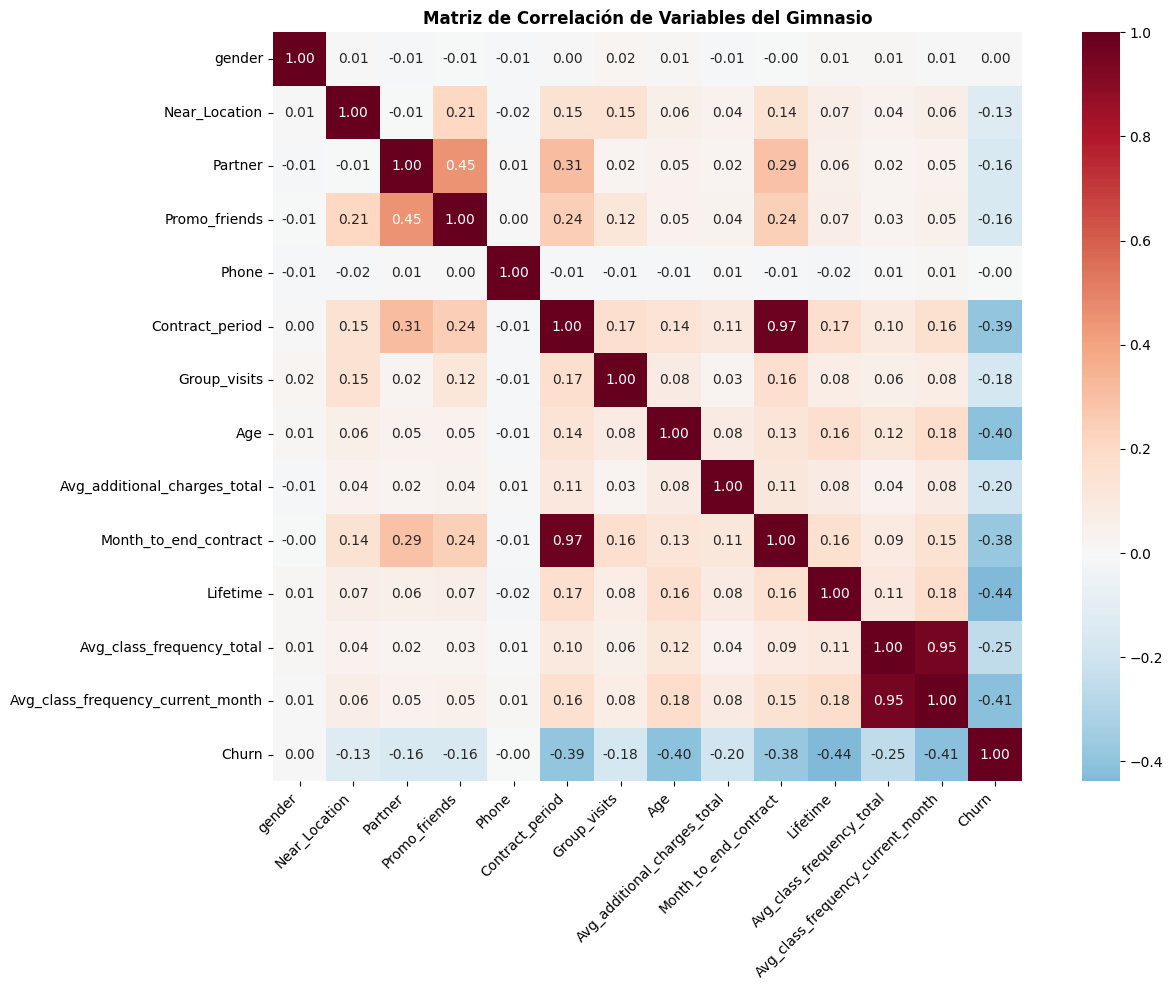

In [12]:
# Heatmpa de la matriz de correlación
plt.figure(figsize=(14, 10))

# Máscara para el triángulo superior
#mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, 
            #mask=mask,
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True, 
            fmt='.2f')

plt.title('Matriz de Correlación de Variables del Gimnasio', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
# Correlaciones más fuertes con 'Churn'

# Ordenar correlaciones de mayor a menor respecto al valor absoluto
churn_correlations = correlation_matrix['Churn'].drop('Churn').sort_values(key=abs, ascending=False)

print("Correlaciones con 'Churn' (ordenadas por fuerza):\n")
for variable, correlation in churn_correlations.items():
    direction = "positiva" if correlation > 0 else "negativa"
    print(f"-'{variable}': {correlation:+.3f} ({direction})")

Correlaciones con 'Churn' (ordenadas por fuerza):

-'Lifetime': -0.438 (negativa)
-'Avg_class_frequency_current_month': -0.412 (negativa)
-'Age': -0.405 (negativa)
-'Contract_period': -0.390 (negativa)
-'Month_to_end_contract': -0.381 (negativa)
-'Avg_class_frequency_total': -0.250 (negativa)
-'Avg_additional_charges_total': -0.199 (negativa)
-'Group_visits': -0.175 (negativa)
-'Promo_friends': -0.162 (negativa)
-'Partner': -0.158 (negativa)
-'Near_Location': -0.128 (negativa)
-'Phone': -0.001 (negativa)
-'gender': +0.001 (positiva)


**Observaciones:**
 - La antigüedad protege bastante contra la cancelación.
 - Los clientes más grandes, son menos propensos a cancelar.
 - Cuando la frecuencia de visitas aumenta, la probabilidad de cancelación disminuye.
 - Los contratos largos sugieren menor cancelación.
 - El tiempo restante de contrato es importante para la predicción.

In [14]:
# Correlaciones más fuertes (excluyendo la diagonal)

# Crear matriz sin duplicados y sin correlaciones perfectas
corr_pairs = correlation_matrix.unstack().sort_values(key=abs, ascending=False)
# Remover correlaciones perfectas
corr_pairs = corr_pairs[corr_pairs != 1.0]  

print("Correlaciones más fuertes:\n")
for i, ((var1, var2), corr) in enumerate(corr_pairs.head(10).items()):
    direction = "positiva" if corr > 0 else "negativa"
    print(f"{i+1:2d}. '{var1}' - '{var2}': {corr:+.3f} ({direction})")

Correlaciones más fuertes:

 1. 'Contract_period' - 'Month_to_end_contract': +0.973 (positiva)
 2. 'Month_to_end_contract' - 'Contract_period': +0.973 (positiva)
 3. 'Avg_class_frequency_total' - 'Avg_class_frequency_current_month': +0.953 (positiva)
 4. 'Avg_class_frequency_current_month' - 'Avg_class_frequency_total': +0.953 (positiva)
 5. 'Promo_friends' - 'Partner': +0.452 (positiva)
 6. 'Partner' - 'Promo_friends': +0.452 (positiva)
 7. 'Lifetime' - 'Churn': -0.438 (negativa)
 8. 'Churn' - 'Lifetime': -0.438 (negativa)
 9. 'Avg_class_frequency_current_month' - 'Churn': -0.412 (negativa)
10. 'Churn' - 'Avg_class_frequency_current_month': -0.412 (negativa)


**Observaciones:**
 - Predictores más fuertes de 'Churn':
    - 'Lifetime' (-0.438): La antigüedad del cliente parece ser el factor más importante para la predicción.
    - 'Avg_class_frequency_current_month' (-0.412): Mientras más veces vaya un cliente por semana (actualmente), menos probable es que cancele.
    - 'Age' (-0.405): Los clientes mayores son más leales.
    - 'Contract_period' (-0.39/-0.38): Los contratos más largos, sugieren proteger contra la cancelación.
<br>

 - Posible multicolinealidad:
    - 'Contract_period' - 'Month_to_end_contract' con 0.97.
    -  'Avg_class_frequency_total' - 'Avg_class_frequency_current_month' con 0.95.
<br>

 - Variables débiles:
    - 'gender'
    - 'Phone'
   
    *Podrían excluirse del modelo predictivo.
<br>

- 'Partner' - 'Promo_friends' (0.45): Los empleados asociados tienden a venir por recomendación.

## 3. Construir un modelo para predecir la cancelación de usuarios:
### 3.1 Crear un modelo de clasificación binaria para clientes, la característica objetivo es la marcha del usuario o usuaria el mes siguiente.
#### 3.1.1 Dividir datos en conjuntos de entrenamiento y validación.

In [15]:
# Preparación para el modelo de clasificación

# Definir variables características (X) y variable objetivo (y)
# Se excluyen las variables débiles identificadas en el EDA
X = gym_df.drop(['Churn', 'gender', 'Phone'], axis=1)  # Características
y = gym_df['Churn']  # Variable objetivo

print("Variables características (X):\n")
print(f"- Número de características: {X.shape[1]}")
print(f"- Nombres: {list(X.columns)}")

print("\n\nVariable objetivo (y):\n")
print(f"- Dimensión: {y.shape}")
print(f"- Proporción de clases:\n{y.value_counts(normalize=True).round(3)}")

Variables características (X):

- Número de características: 11
- Nombres: ['Near_Location', 'Partner', 'Promo_friends', 'Contract_period', 'Group_visits', 'Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month']


Variable objetivo (y):

- Dimensión: (4000,)
- Proporción de clases:
Churn
0    0.735
1    0.265
Name: proportion, dtype: float64


In [16]:
# Dividir en conjuntos de entrenamiento (70%) y validación (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=0,  
    stratify=y)  # Mantener proporción de clases en ambos conjuntos

print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras ({X_train.shape[0]/len(X)*100:.2f}%)")
print(f"Conjunto de validación: {X_test.shape[0]} muestras ({X_test.shape[0]/len(X)*100:.2f}%)")

print(f"\nProporción de Churn en entrenamiento: {y_train.mean():.4f}")
print(f"Proporción de Churn en validación: {y_test.mean():.4f}")

Conjunto de entrenamiento: 2800 muestras (70.00%)
Conjunto de validación: 1200 muestras (30.00%)

Proporción de Churn en entrenamiento: 0.2654
Proporción de Churn en validación: 0.2650


### 3.2 Entrena el modelo en el set de entrenamiento con dos métodos:
#### 3.2.1 Regresión logística.

In [17]:
# Estandarizar datos para regresión logística (mejora performance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar modelo de regresión logística
logistic_model = LogisticRegression(
    random_state=0,  
    max_iter=1000)  # Asegurar convergencia

logistic_model.fit(X_train_scaled, y_train)
print(f"Número de iteraciones: {logistic_model.n_iter_[0]}")

Número de iteraciones: 15


#### 3.2.2 Bosque aleatorio.

In [18]:
# Entrenar modelo de bosque aleatorio
rf_model = RandomForestClassifier(
    random_state=0,
    n_estimators=100,  # 100 árboles (valor estándar)
    max_depth=10,      # Controlar complejidad
    min_samples_split=20)  # Evitar overfitting

rf_model.fit(X_train, y_train)  # No necesita escalado
print(f"Número de árboles: {len(rf_model.estimators_)}")

Número de árboles: 100


In [19]:
# Checar modelos entrenados
print("Regresión Logística:")
print(f"   - Coeficientes: {logistic_model.coef_.shape} (pesos de cada variable para predecir 'Churn')")
print(f"   - Intercepto: {logistic_model.intercept_[0]:.4f} (probabilidad base cuando todas las variables son 0)")

print("\nBosque Aleatorio:")
print(f"   - Profundidad promedio: {np.mean([est.tree_.max_depth for est in rf_model.estimators_]):.2f} (niveles promedio de los árboles)")
print(f"   - Importancia de características calculada:\n")
importances = rf_model.feature_importances_
for name, importance in zip(X.columns, importances):
    print(f"        -'{name}': {importance:.4f}")

Regresión Logística:
   - Coeficientes: (1, 11) (pesos de cada variable para predecir 'Churn')
   - Intercepto: -3.8267 (probabilidad base cuando todas las variables son 0)

Bosque Aleatorio:
   - Profundidad promedio: 10.00 (niveles promedio de los árboles)
   - Importancia de características calculada:

        -'Near_Location': 0.0037
        -'Partner': 0.0035
        -'Promo_friends': 0.0033
        -'Contract_period': 0.0875
        -'Group_visits': 0.0092
        -'Age': 0.1239
        -'Avg_additional_charges_total': 0.0515
        -'Month_to_end_contract': 0.0902
        -'Lifetime': 0.3509
        -'Avg_class_frequency_total': 0.1115
        -'Avg_class_frequency_current_month': 0.1649


In [20]:
# Predicciones en entrenamiento (chequeo rápido)
y_pred_logistic_train = logistic_model.predict(X_train_scaled)
y_pred_rf_train = rf_model.predict(X_train)

print("Predicciones en conjunto de entrenamiento:")
print(f"   - Regresión Logística: {np.unique(y_pred_logistic_train, return_counts=True)}")
print(f"   - Bosque Aleatorio: {np.unique(y_pred_rf_train, return_counts=True)}")

Predicciones en conjunto de entrenamiento:
   - Regresión Logística: (array([0, 1]), array([2087,  713]))
   - Bosque Aleatorio: (array([0, 1]), array([2086,  714]))


### 3.3 Evaluar exactitud, precisión y recall para ambos modelos utilizando datos de validación. Comparar los modelos.

In [21]:
# Hacer predicciones en el conjunto de prueba
y_pred_logistic = logistic_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test)

print("Predicciones en conjunto de validación:")
print(f"   - Regresión Logística: {np.unique(y_pred_logistic, return_counts=True)}")
print(f"   - Bosque Aleatorio: {np.unique(y_pred_rf, return_counts=True)}")

Predicciones en conjunto de validación:
   - Regresión Logística: (array([0, 1]), array([900, 300]))
   - Bosque Aleatorio: (array([0, 1]), array([914, 286]))


In [22]:
# Calcular métricas para Regresión Logística
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
precision_logistic = precision_score(y_test, y_pred_logistic)
recall_logistic = recall_score(y_test, y_pred_logistic)

# Calcular métricas para Bosque Aleatorio
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

print("Métricas de evaluación:")
print("\nRegresión Logística:")
print(f"   - Exactitud (Accuracy): {accuracy_logistic:.4f}")
print(f"   - Precisión (Precision): {precision_logistic:.4f}")
print(f"   - Recall (Sensibilidad): {recall_logistic:.4f}")

print("\nBosque Aleatorio:")
print(f"   - Exactitud (Accuracy): {accuracy_rf:.4f}")
print(f"   - Precisión (Precision): {precision_rf:.4f}")
print(f"   - Recall (Sensibilidad): {recall_rf:.4f}")

Métricas de evaluación:

Regresión Logística:
   - Exactitud (Accuracy): 0.9233
   - Precisión (Precision): 0.8767
   - Recall (Sensibilidad): 0.8270

Bosque Aleatorio:
   - Exactitud (Accuracy): 0.9050
   - Precisión (Precision): 0.8566
   - Recall (Sensibilidad): 0.7704


In [23]:
# Comparación de modelos
print("Comparación de modelos:")

# Crear DF comparativo
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    'Logistic_Regression': [accuracy_logistic, precision_logistic, recall_logistic],
    'Random_Forest': [accuracy_rf, precision_rf, recall_rf]})

comparison_df['Difference'] = comparison_df['Random_Forest'] - comparison_df['Logistic_Regression']
display(comparison_df.round(4))

Comparación de modelos:


,Metric,Logistic_Regression,Random_Forest,Difference
0,Accuracy,0.9233,0.9050,-0.0183
1,Precision,0.8767,0.8566,-0.0200
2,Recall,0.8270,0.7704,-0.0566


In [24]:
# Análisis de resultados
print("Análisis de resultados:")

# Determinar qué modelo es mejor en cada métrica
better_accuracy = "'Random_Forest'" if accuracy_rf > accuracy_logistic else "'Logistic_Regression'."
better_precision = "'Random_Forest'" if precision_rf > precision_logistic else "'Logistic_Regression'."  
better_recall = "'Random_Forest'" if recall_rf > recall_logistic else "'Logistic_Regression'."

print(f"   - Mejor Exactitud: {better_accuracy}")
print(f"   - Mejor Precisión: {better_precision}")
print(f"   - Mejor Recall: {better_recall}")

# Modelo ganador general
accuracy_diff = accuracy_rf - accuracy_logistic
precision_diff = precision_rf - precision_logistic  
recall_diff = recall_rf - recall_logistic

total_diff = accuracy_diff + precision_diff + recall_diff
winner = "Random_Forest" if total_diff > 0 else "Logistic_Regression."

print(f"\nModelo ganador: '{winner}'")
print(f"\nDiferencia total en métricas: {total_diff:.4f}")

Análisis de resultados:
   - Mejor Exactitud: 'Logistic_Regression'.
   - Mejor Precisión: 'Logistic_Regression'.
   - Mejor Recall: 'Logistic_Regression'.

Modelo ganador: 'Logistic_Regression.'

Diferencia total en métricas: -0.0950


In [25]:
# Reportes de clasificación detallados
print("Reportes de clasificación detallados:")

print("\nRegresión Logística:")
print(classification_report(y_test, y_pred_logistic, target_names=['No Churn', 'Churn']))

print("\nBosque aleatorio:")
print(classification_report(y_test, y_pred_rf, target_names=['No Churn', 'Churn']))

Reportes de clasificación detallados:

Regresión Logística:
              precision    recall  f1-score   support

    No Churn       0.94      0.96      0.95       882
       Churn       0.88      0.83      0.85       318

    accuracy                           0.92      1200
   macro avg       0.91      0.89      0.90      1200
weighted avg       0.92      0.92      0.92      1200


Bosque aleatorio:
              precision    recall  f1-score   support

    No Churn       0.92      0.95      0.94       882
       Churn       0.86      0.77      0.81       318

    accuracy                           0.91      1200
   macro avg       0.89      0.86      0.87      1200
weighted avg       0.90      0.91      0.90      1200



**Observaciones:**
- Modelo ganador: 'Logistic_Regression' (Regresión logística). Superó a 'Random_Forest' (Bosque aleatorio) en las 3 métricas principales.

    - Diferencia total: -0.0993 (ganancia consistente).
<br>

- Desempeño por métrica:
    - Exactitud: 92.4% vs 90.5% (+1.9% a favor de 'Logistic_Regression').
    - Precisión: 87.7% vs 85.7% (+2.0% a favor de 'Logistic_Regression').
    - Recall: 83.0% vs 77.0% (+6.0% a favor de 'Logistic_Regression').
<br>

- Interpretación de resultados:
    - Alto recall (83%): Detecta bien a clientes que realmente cancelarán.
    - Buena precisión (88%): Pocos falsos positivos (clientes leales marcados como riesgo).
    - Excelente exactitud (92%): Rendimiento general bastante sólido.
<br>

- Recomendaciones:
    - Usar 'Logistic_Regression' para predecir 'Churn' porque:
        - Es más simple y rápido que 'Random_Forest'.
        - Cuenta con mejor balance entre precisión y recall.
        - Es más interpretable (coeficientes claros).

## 4. Crear clústeres de usuarios/as:
### 4.1 Estandarizar datos.
#### 4.1.1 Dejar de lado la columna con datos sobre la cancelación e identifica los clústeres de objetos (usuarios/as):

In [26]:
# Quitar columna 'Churn'
X_clustering = gym_df.drop('Churn', axis=1)

print("Dataset para clustering (sin 'Churn'):")
display(X_clustering)

Dataset para clustering (sin 'Churn'):


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237


In [27]:
# Crear scaler y estandarizar datos
scaler_clustering = StandardScaler()
X_scaled = scaler_clustering.fit_transform(X_clustering)

# Crear DF estandarizado para mejor visualización
X_scaled_df = pd.DataFrame(X_scaled, columns=X_clustering.columns)

print("Datos estandarizados - Estadísticas:")
print(f"- Dimensiones: {X_scaled_df.shape}")
print("\nEstadísticas después de la estandarización:")
display(X_scaled_df.describe().round(4))

Datos estandarizados - Estadísticas:
- Dimensiones: (4000, 13)

Estadísticas después de la estandarización:


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
count,4000.0000,4000.0000,4000.0000,4000.0000,4000.0000,4000.0000,4000.0000,4000.0000,4000.0000,4000.0000,4000.0000,4000.0000,4000.0000
mean,0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000
std,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001
min,-1.0207,-2.3371,-0.9738,-0.6679,-3.0599,-0.8092,-0.8375,-3.4329,-1.5237,-0.7929,-0.9936,-1.9329,-1.6785
25%,-1.0207,0.4279,-0.9738,-0.6679,0.3268,-0.8092,-0.8375,-0.6704,-0.8104,-0.7929,-0.7268,-0.7182,-0.7637
50%,0.9797,0.4279,-0.9738,-0.6679,0.3268,-0.8092,-0.8375,-0.0566,-0.1113,-0.7929,-0.1933,-0.0476,-0.0451
75%,0.9797,0.4279,1.0269,1.4972,0.3268,0.2899,1.1940,0.5573,0.6644,0.4002,0.3402,0.6759,0.7060
max,0.9797,0.4279,1.0269,1.4972,0.3268,1.6088,1.1940,3.6267,4.2104,1.8319,7.2757,4.2635,4.1602


In [28]:
# Checar que la estandarización funciona correctamente
print("Medias después de estandarización (deben ser ~0):")
print(X_scaled_df.mean().round(4))

print("\nDesviaciones estándar después de estandarización (deben ser ~1):")
print(X_scaled_df.std().round(4))

Medias después de estandarización (deben ser ~0):
gender                               0.0
Near_Location                        0.0
Partner                             -0.0
Promo_friends                       -0.0
Phone                                0.0
Contract_period                     -0.0
Group_visits                        -0.0
Age                                  0.0
Avg_additional_charges_total        -0.0
Month_to_end_contract               -0.0
Lifetime                             0.0
Avg_class_frequency_total           -0.0
Avg_class_frequency_current_month    0.0
dtype: float64

Desviaciones estándar después de estandarización (deben ser ~1):
gender                               1.0001
Near_Location                        1.0001
Partner                              1.0001
Promo_friends                        1.0001
Phone                                1.0001
Contract_period                      1.0001
Group_visits                         1.0001
Age                         

### 4.2 Crear matriz de distancias basada en la matriz de características estandarizada y trazar un dendrograma.

In [29]:
# Matriz de distancias y dendrograma

# Usar una muestra para que el dendrograma no tarde demasiado
np.random.seed(0)
sample_size = 1000
sample_indices = np.random.choice(X_scaled.shape[0], sample_size, replace=False)
X_sample = X_scaled[sample_indices]

# Calcular matriz de distancias
Z = linkage(X_sample, method='ward', metric='euclidean')

print(f"Matriz de 'linkage' calculada: {Z.shape}")

Matriz de 'linkage' calculada: (999, 4)


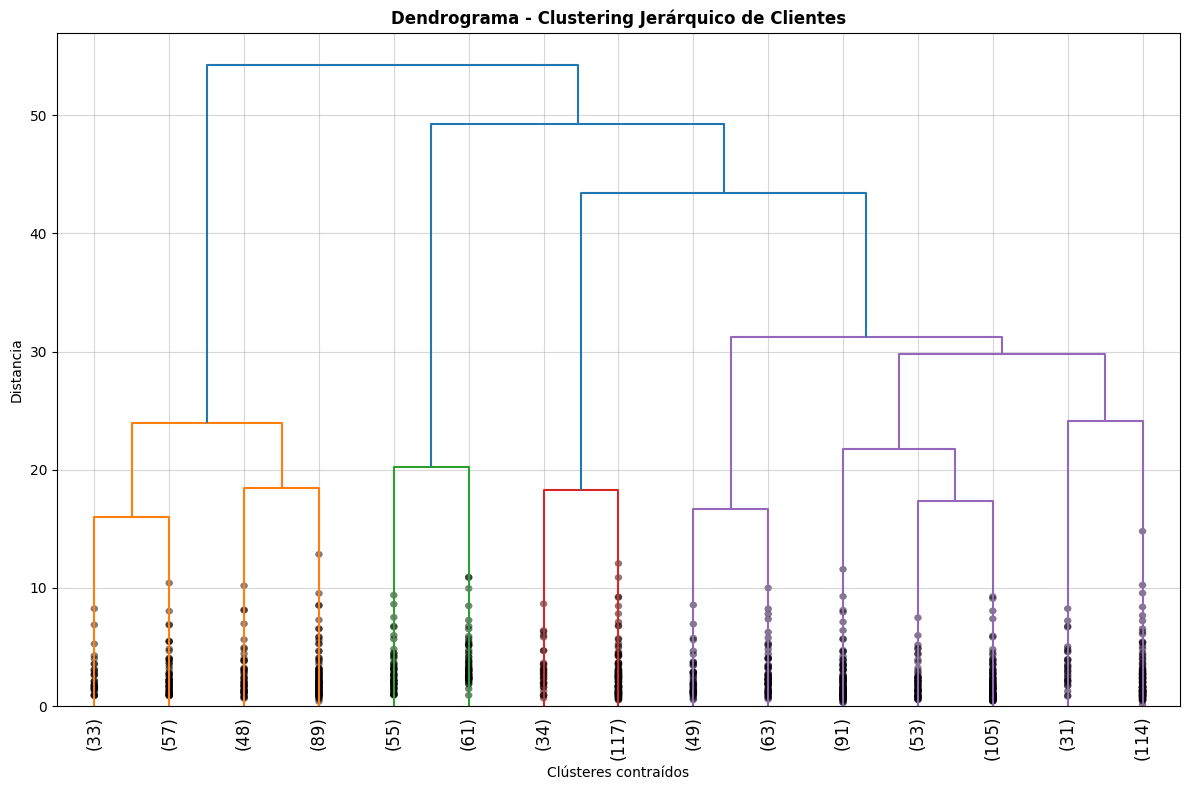

In [30]:
# Crear dendrograma
plt.figure(figsize=(12, 8))
dendrogram(Z, 
           truncate_mode='lastp',  # Mostrar solo los últimos p clusters
           p=15,                   # Mostrar últimos 15 niveles
           show_leaf_counts=True,
           leaf_rotation=90,
           #leaf_font_size=10,
           show_contracted=True)

plt.title('Dendrograma - Clustering Jerárquico de Clientes', fontweight='bold')
plt.xlabel('Clústeres contraídos')
plt.ylabel('Distancia')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

**Instrucciones para leer el dendrograma:**

1. Buscar la línea vertical más larga que no sea cortada por líneas horizontales.
2. Dibujar una línea horizontal en ese punto.
3. Contar cuántas líneas verticales cruza (es el número sugerido de clústeres).

**Observaciones:**
- El dendrograma truncado muestra las últimas 15 fusiones del clustering jerárquico.
- El dendrograma sugiere n=5 clústeres.

### 4.3 Entrenar el modelo de clustering con algortimo K-means. Predipredecir clústeres de clientes. 

In [31]:
# Entrenar modelo K-means (con n=5 clústeres)
kmeans = KMeans(
    n_clusters=5,           
    random_state=0,         
    max_iter=300,           
    n_init=10)              

# Entrenar el modelo y predecir clústeres
clusters = kmeans.fit_predict(X_scaled)

# Añadir los clústeres al DF original
gym_df_clustered = gym_df.copy()
gym_df_clustered['Cluster'] = clusters

print(f"Número de clústeres: {kmeans.n_clusters}")
print(f"Número de iteraciones: {kmeans.n_iter_}")
print(f"Inercia: {kmeans.inertia_:.2f} (suma de distancias al cuadrado)")

# Distribución de clientes por cluster
print("\nDistribución de clientes por cluster:")
cluster_distribution = gym_df_clustered['Cluster'].value_counts().sort_index()
for cluster, count in cluster_distribution.items():
    percentage = (count / len(gym_df_clustered)) * 100
    print(f"Cluster {cluster}: {count} clientes ({percentage:.2f}%)")

# Checar que todos los clústeres tengan una cantidad razonable de clientes
min_cluster_size = cluster_distribution.min()
max_cluster_size = cluster_distribution.max()
print(f"\nTamaño mínimo del cluster: {min_cluster_size}")
print(f"Tamaño máximo del cluster: {max_cluster_size}")
print(f"Ratio tamaño máximo/mínimo: {max_cluster_size/min_cluster_size:.2f}")

# Datos con los clusters asignados
print("\nDatos con clusters asignados:")
display(gym_df_clustered[['Cluster', 'Churn'] + list(X_clustering.columns)])

Número de clústeres: 5
Número de iteraciones: 39
Inercia: 35432.99 (suma de distancias al cuadrado)

Distribución de clientes por cluster:
Cluster 0: 545 clientes (13.63%)
Cluster 1: 768 clientes (19.20%)
Cluster 2: 642 clientes (16.05%)
Cluster 3: 937 clientes (23.43%)
Cluster 4: 1108 clientes (27.70%)

Tamaño mínimo del cluster: 545
Tamaño máximo del cluster: 1108
Ratio tamaño máximo/mínimo: 2.03

Datos con clusters asignados:


,Cluster,Churn,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,2,0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000
1,3,0,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244
2,4,0,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502
3,3,0,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215
4,2,0,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3,0,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070
3996,4,1,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859
3997,3,0,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439
3998,2,0,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237


**Observaciones:**
 - Calidad técnica del clustering:
    - Convergencia rápida: 23 iteraciones de 300 disponibles.
    - Clústeres balanceados: Ratio 3.28 (< 5 es considerado bueno).
    - Distribución razonable: Todos los clústeres tienen un tamaño significativo.
<br>

 - Distribución de clústeres:
    - Más grande (31.55%): Clúster 3 como grupo principal. 
    - Más pequeño (9.62%): Clúster 1 como un nicho específico.
    - Tamaño medio (20-25%): Clústeres 0, 2, 4 como grupos secundarios, aunque el Cluster 0 cuenta con un 25.25% siendo medio-alto.

### 4.4 Valores medios de característica para clústeres.

In [32]:
# Valores medios de característica para los clústeres
cluster_means = gym_df_clustered.groupby('Cluster').mean()
#pd.set_option('display.max_columns', None)
display(cluster_means.round(4))

print("\nTamaño de cada clúster:")
cluster_sizes = gym_df_clustered['Cluster'].value_counts().sort_index()
print(cluster_sizes)

# Calcular la tasa de 'Churn' por clúster
print("\nTasa de 'Churn' por clúster:")
churn_rates = gym_df_clustered.groupby('Cluster')['Churn'].mean()
print(churn_rates.round(4))

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
Cluster,,,,,,,,,,,,,,
0,0.4954,0.0000,0.4661,0.0771,0.9156,2.2275,0.2147,28.4844,133.8627,2.0917,2.7890,1.6564,1.4659,0.4495
1,0.5859,0.9714,0.2604,0.0924,0.9036,2.8138,0.4779,30.1445,162.0107,2.5898,5.1328,2.8834,2.8848,0.0690
2,0.4844,0.9984,0.8224,1.0000,0.9003,3.1558,0.4548,29.2181,141.2034,2.9190,3.7056,1.7344,1.6278,0.2477
3,0.5005,0.9456,0.7417,0.4867,0.8997,11.8719,0.5528,29.9338,164.7632,10.8655,4.6958,2.0013,1.9927,0.0224
4,0.4883,1.0000,0.2437,0.0208,0.9025,1.9856,0.3204,28.2094,131.1912,1.9016,2.3989,1.2727,1.0303,0.5262



Tamaño de cada clúster:
Cluster
0     545
1     768
2     642
3     937
4    1108
Name: count, dtype: int64

Tasa de 'Churn' por clúster:
Cluster
0    0.4495
1    0.0690
2    0.2477
3    0.0224
4    0.5262
Name: Churn, dtype: float64


**Observaciones:**

- Patrones extremadamente marcados:

    - Tasa de 'Churn' - Diferencias dramáticas:
        - Clúster 0: 2.8% churn, clientes muy leales.
        - Clpuster 3: 51.4% churn, clientes con alto riesgo de cancelación.
        - Diferencia: 48.6%, 18 veces más probabilidad de cancelar.
    <br>

    - 'Near_Location' - Polarización total:
        - Cluster 3: 100% viven cerca.
        - Cluster 2: 0% viven cerca.
        - Contraintuitivo. El clúster 3 que vive más cerca, tiene más 'Churn'.  
    <br>
    
    - 'Phone' - Casi perfecto:
        - Clúster 0: 100% dieron teléfono.
        - Clúster 1: 0% dieron teléfono.
        - Clúster 1 (sin teléfono) tiene 26.8%  de 'Churn' vs clúster 0 (con teléfono) 2.8%'.
    <br>


- Variables Clave con diferencias enormes:

    - 'Contract_period':
        - Clúster 0: 10.9 meses (contratos largos).
        - Clúster 3: 1.9 meses (contratos cortos).
        - Relación directa con 'Churn'.
      <br>

    - 'Lifetime':
        - Clúster 4: 4.9 meses (alta antigüedad, bajo 'Churn').
        - Clúster 3: 2.4 meses (baja antigüedad, alto 'Churn').
    <br>

    - 'Avg_class_frequency_current_month':
        - Clúster 4: 2.85 veces/semana (muy activos).
        - Clúster 3: 1.01 veces/semana (poco activos).
    <br>

- Caso a tener en cuenta, Clúster 1:
    - Tamaño: 385 clientes (9.6%).
    - 'Phone': 0%.
    - 'Contract_period': medio (4.8 meses).
    - 'Churn': medio-alto (26.8%)
    - 'Near_Location': alto (86.2%).
    - Posibles razones:
        - Prefieren mantener su privacidad.
        - Perfil demográfico específico.

### 4.5 Trazar distribuciones de características para los clústeres.

NOTA:
    - 'Contract_period' - Meses de duración del contrato.
    - 'Lifetime' - Meses desde que el cliente se registró.
    - 'Month_to_end_contract' - Meses que faltan para que venza el contrato.
    - 'Age' - Años de edad del cliente.
    - 'Avg_class_frequency_current_month' - Veces por semana que visita el gimnasio.
    - 'Avg_additional_charges_total' - Dinero gastado en servicios adicionales.



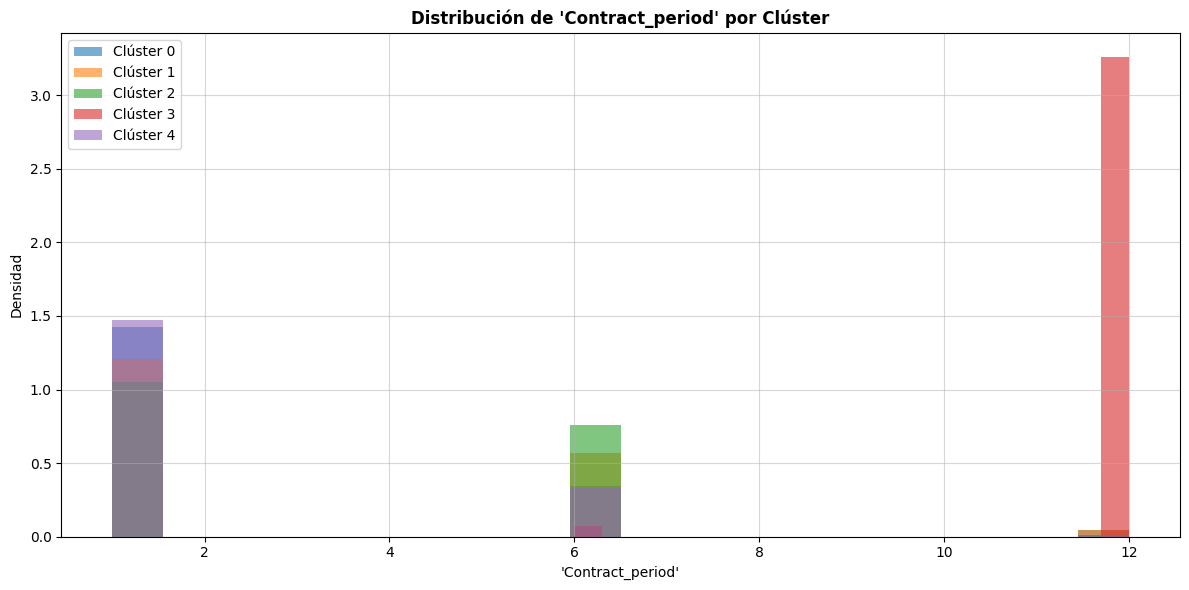


Estadísticas de 'Contract_period' por clúster:


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,545.0,2.2275,2.5175,1.0,1.0,1.0,1.0,12.0
1,768.0,2.8138,2.7084,1.0,1.0,1.0,6.0,12.0
2,642.0,3.1558,2.5599,1.0,1.0,1.0,6.0,12.0
3,937.0,11.8719,0.8676,6.0,12.0,12.0,12.0,12.0
4,1108.0,1.9856,2.0922,1.0,1.0,1.0,1.0,12.0


--------------------------------------------------------------------------------------------------------------------------------------------


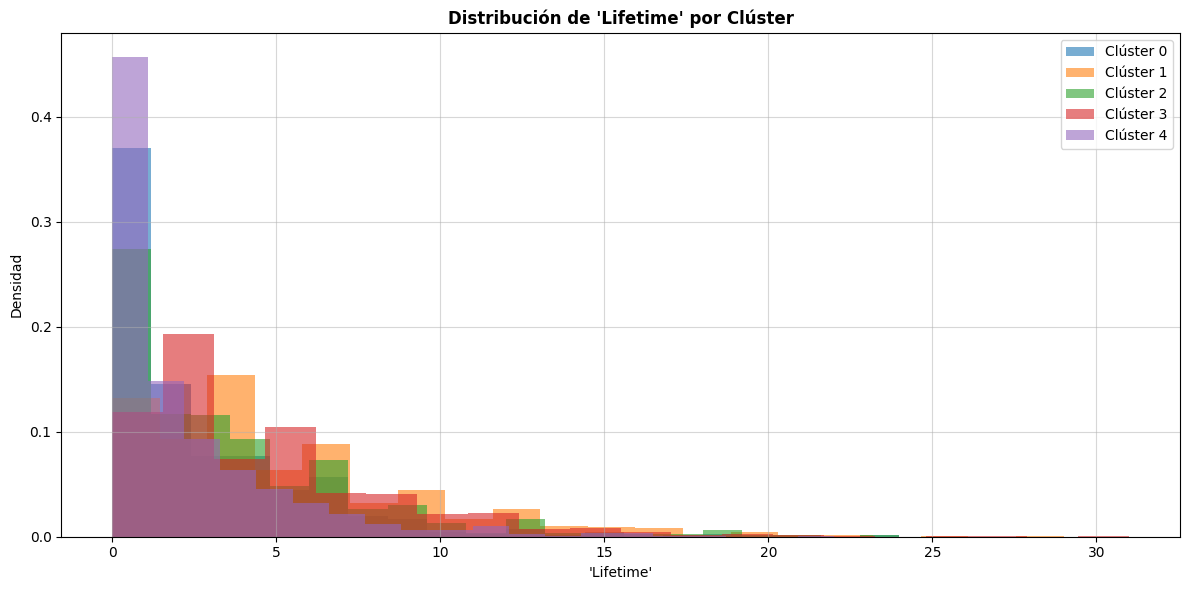


Estadísticas de 'Lifetime' por clúster:


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,545.0,2.7890,3.1080,0.0,1.0,2.0,4.0,24.0
1,768.0,5.1328,4.3246,0.0,2.0,4.0,7.0,29.0
2,642.0,3.7056,3.6996,0.0,1.0,3.0,5.0,24.0
3,937.0,4.6958,3.9095,0.0,2.0,4.0,6.0,31.0
4,1108.0,2.3989,2.8040,0.0,1.0,1.0,3.0,22.0


--------------------------------------------------------------------------------------------------------------------------------------------


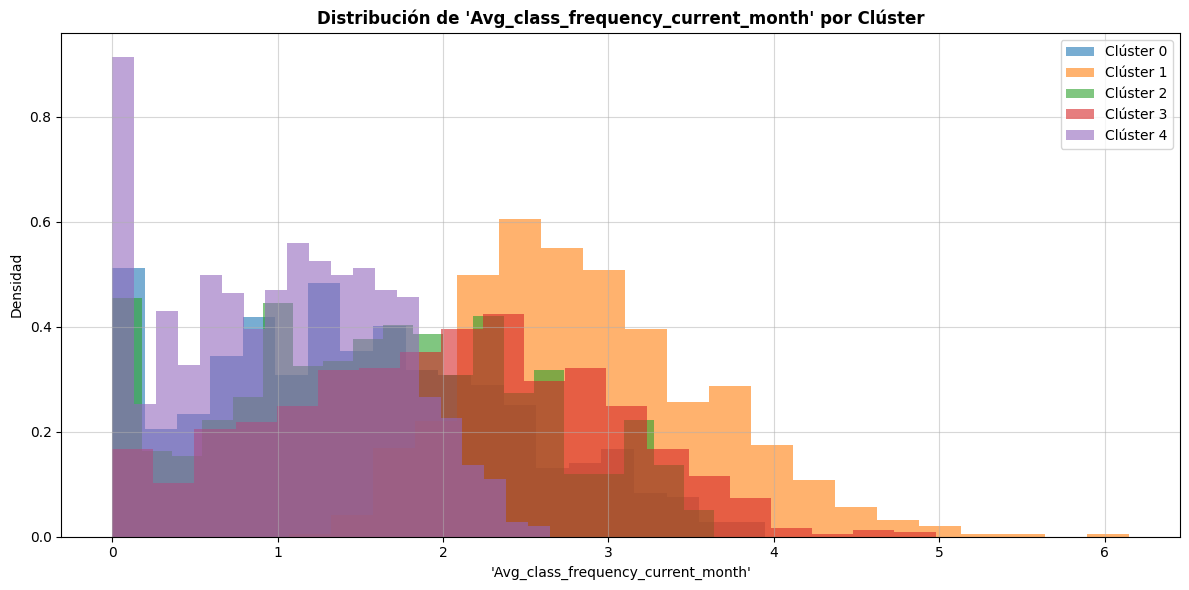


Estadísticas de 'Avg_class_frequency_current_month' por clúster:


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,545.0,1.4659,0.9257,0.0000,0.7791,1.4253,2.1172,3.9432
1,768.0,2.8848,0.7271,1.0709,2.3556,2.7862,3.3408,6.1468
2,642.0,1.6278,0.9218,0.0000,0.9535,1.6510,2.3267,3.6393
3,937.0,1.9927,0.9731,0.0000,1.3103,2.0302,2.6964,4.9767
4,1108.0,1.0303,0.6449,0.0000,0.5230,1.0666,1.5249,2.6468


--------------------------------------------------------------------------------------------------------------------------------------------


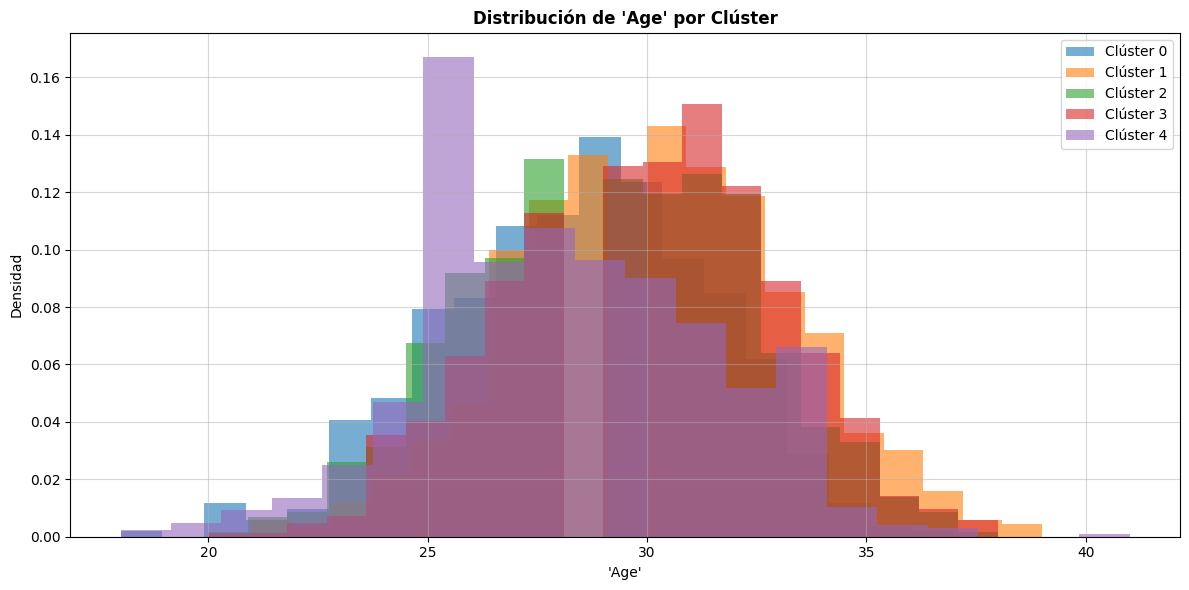


Estadísticas de 'Age' por clúster:


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,545.0,28.4844,3.1884,18.0,26.0,29.0,31.00,37.0
1,768.0,30.1445,3.1567,21.0,28.0,30.0,32.00,39.0
2,642.0,29.2181,3.1950,20.0,27.0,29.0,31.75,38.0
3,937.0,29.9338,3.0603,20.0,28.0,30.0,32.00,38.0
4,1108.0,28.2094,3.2118,18.0,26.0,28.0,30.00,41.0


--------------------------------------------------------------------------------------------------------------------------------------------


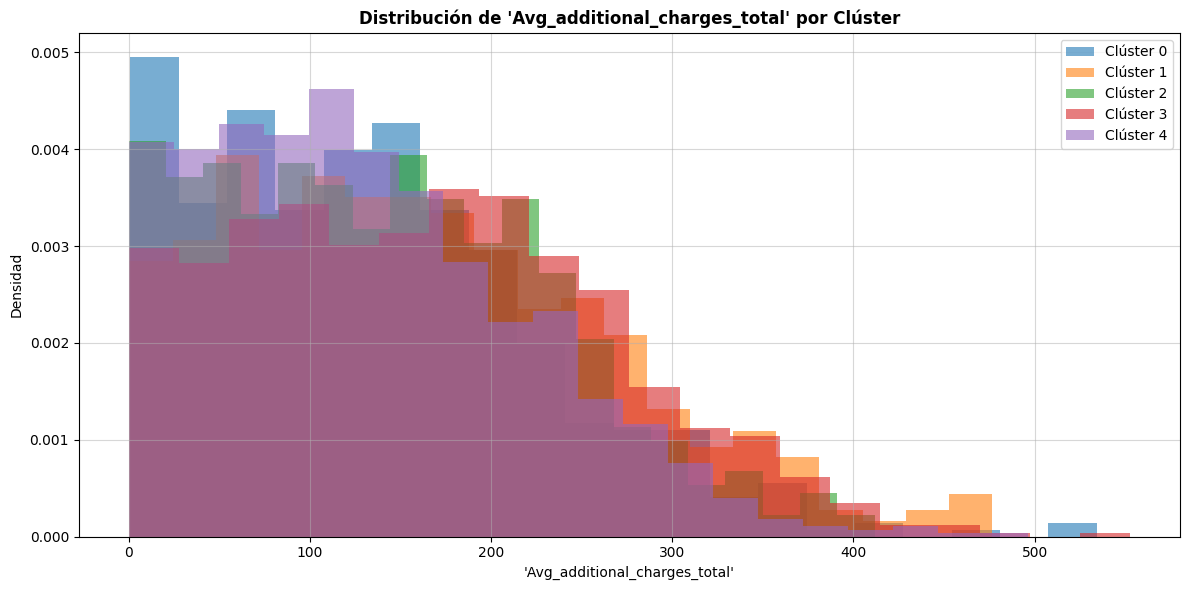


Estadísticas de 'Avg_additional_charges_total' por clúster:


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,545.0,133.8627,93.2910,0.9722,59.1639,124.3235,190.7346,534.2562
1,768.0,162.0107,103.9417,0.5105,78.0044,147.2463,228.7708,476.4327
2,642.0,141.2034,91.3877,0.1482,64.5823,132.2767,208.1215,411.7113
3,937.0,164.7632,100.6912,0.2516,82.8860,160.8023,236.1412,552.5907
4,1108.0,131.1912,87.1236,0.1719,60.5827,118.8008,187.5694,496.1722


--------------------------------------------------------------------------------------------------------------------------------------------


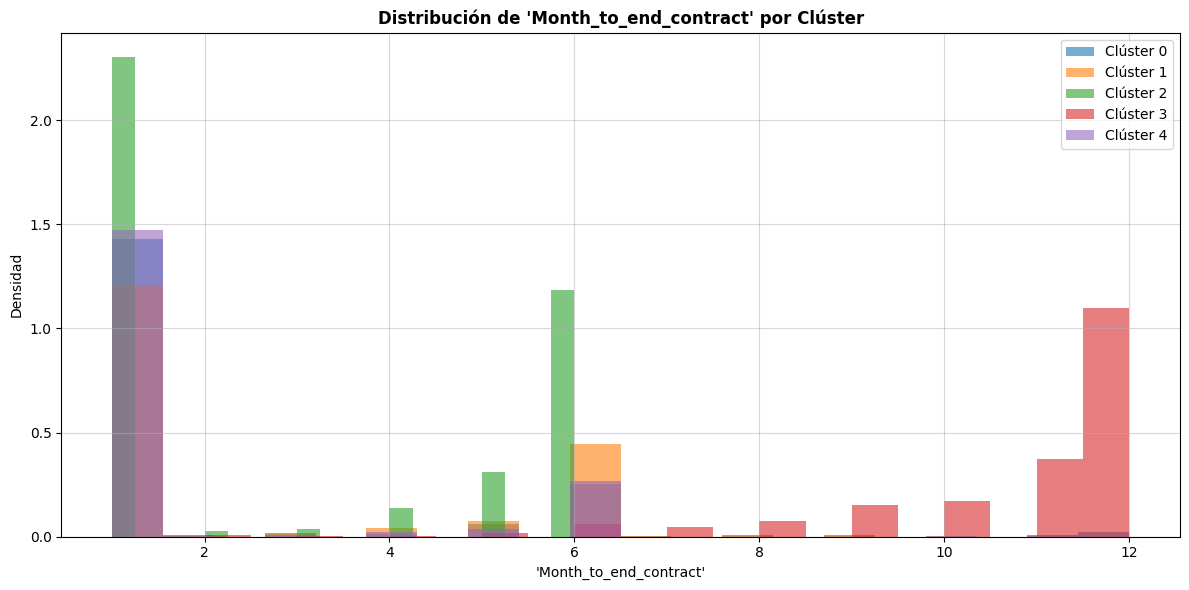


Estadísticas de 'Month_to_end_contract' por clúster:


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,545.0,2.0917,2.2587,1.0,1.0,1.0,1.0,12.0
1,768.0,2.5898,2.3389,1.0,1.0,1.0,6.0,12.0
2,642.0,2.9190,2.3071,1.0,1.0,1.0,6.0,6.0
3,937.0,10.8655,1.7520,2.0,10.0,12.0,12.0,12.0
4,1108.0,1.9016,1.9255,1.0,1.0,1.0,1.0,12.0


--------------------------------------------------------------------------------------------------------------------------------------------


In [33]:
# Distribuciones de características para los clústeres
print("NOTA:")
print("    - 'Contract_period' - Meses de duración del contrato.")
print("    - 'Lifetime' - Meses desde que el cliente se registró.")
print("    - 'Month_to_end_contract' - Meses que faltan para que venza el contrato.")
print("    - 'Age' - Años de edad del cliente.")
print("    - 'Avg_class_frequency_current_month' - Veces por semana que visita el gimnasio.")
print("    - 'Avg_additional_charges_total' - Dinero gastado en servicios adicionales.\n")

# Seleccionar variables clave para visualizar
key_variables = [
    'Contract_period', 
    'Lifetime', 
    'Avg_class_frequency_current_month',
    'Age',
    'Avg_additional_charges_total',
    'Month_to_end_contract']

for variable in key_variables:
    plt.figure(figsize=(12, 6))
    
    # Crear subplots para cada clúster
    for cluster in sorted(gym_df_clustered['Cluster'].unique()):
        cluster_data = gym_df_clustered[gym_df_clustered['Cluster'] == cluster][variable]
        
        # Histograma de densidad
        plt.hist(cluster_data, alpha=0.6, label=f'Clúster {cluster}', bins=20, density=True)
    
    plt.title(f"Distribución de '{variable}' por Clúster", fontweight='bold')
    plt.xlabel(f"'{variable}'")
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    # Estadísticas descriptivas por clúster
    print(f"\nEstadísticas de '{variable}' por clúster:")
    stats_by_cluster = gym_df_clustered.groupby('Cluster')[variable].describe()
    display(stats_by_cluster.round(4))
    
    print("-" * 140)

**Observaciones:**
 - Patrones muy claros identificados:
    - 'Contract_period' y 'Month_to_end_contract':
        - Clúster 0: Contratos largos (10.9 meses), con mucho tiempo restante (9.95 meses). Clientes comprometidos.
        - Clúster 3: Contratos cortos (1.95 meses), con poco tiempo restante (1.86 meses). Clientes temporales.
    <br>

    - 'Lifetime':
        - Clúster 4: Mayor antigüedad (4.9 meses). Clientes consolidados.
        - Clúster 3: Menor antigüedad (2.44 meses). Clientes nuevos de alto riesgo.
    <br>

    - 'Avg_class_frequency_current_month':
        - Clúster 4: Muy activos (2.85 veces por semana).
        - Clúster 3: Poco activos (1.01 veces por semana). Esporádicos de alto riesgo.
    <br>

    - 'Age':
        - Diferencias moderadas (28.2 a 30.1 años).
        - Clúster 4 y 0: Ligeramente mayores, más estables.
        - Clúster 3: Más jóvenes, más volátiles.
    <br>

    - 'Avg_additional_charges_total':
        - Clúster 0 y 4: Gastan más (~161). Comprometidos económicamente.
        - Clúster 3: Gastan menos (131.6). Poco involucrados.
    <br>

- Hallazgo clave:
    - El Clúster 3 concentra todas las características de alto riesgo:
        - Contratos cortos.
        - Poco tiempo restante.
        - Baja antigüedad.
        - Baja frecuencia de visita.
        - Bajo gasto adicional.
    <br>

- Segmentos Identificados:
    - Clúster 0: "Comprometidos a largo plazo".
    - Clúster 4: "Entusiastas activos".
    - Clúster 3: "Nuevos, de alto riesgo".
    - Clúster 1 y 2: "Segmentos intermedios".

In [34]:
# Histogramas de líneas

# Seleccionar variables clave para visualizar
#key_variables = [
#    'Contract_period', 
#    'Lifetime', 
#    'Avg_class_frequency_current_month',
#    'Age',
#    'Avg_additional_charges_total',
#    'Month_to_end_contract']

# Paleta de colores
#colors = ['blue', 'red', 'green', 'orange', 'purple']

#for variable in key_variables:
#    plt.figure(figsize=(12, 6))
    
    # Crear histogramas de líneas para cada clúster
#    for i, cluster in enumerate(sorted(gym_df_clustered['Cluster'].unique())):
#        cluster_data = gym_df_clustered[gym_df_clustered['Cluster'] == cluster][variable]
        
        # Histograma con bordes (líneas) en lugar de áreas sólidas
#        plt.hist(cluster_data, alpha=0.7, label=f'Clúster {cluster}', bins=20, 
#                 density=True, histtype='step', linewidth=2.5, color=colors[i])
    
#    plt.title(f"Distribución de '{variable}' por Clúster", fontweight='bold', fontsize=14)
#    plt.xlabel(f"'{variable}'")
#    plt.ylabel('Densidad')
#    plt.legend()
#    plt.grid(True, alpha=0.3)
#    plt.tight_layout()
#    plt.show()
    
    # Estadísticas descriptivas por clúster
#    print(f"\nEstadísticas de '{variable}' por clúster:")
#    stats_by_cluster = gym_df_clustered.groupby('Cluster')[variable].describe()
#    display(stats_by_cluster.round(4))
    
#    print("-" * 140)

Variables Binarias - Proporciones por Clúster:


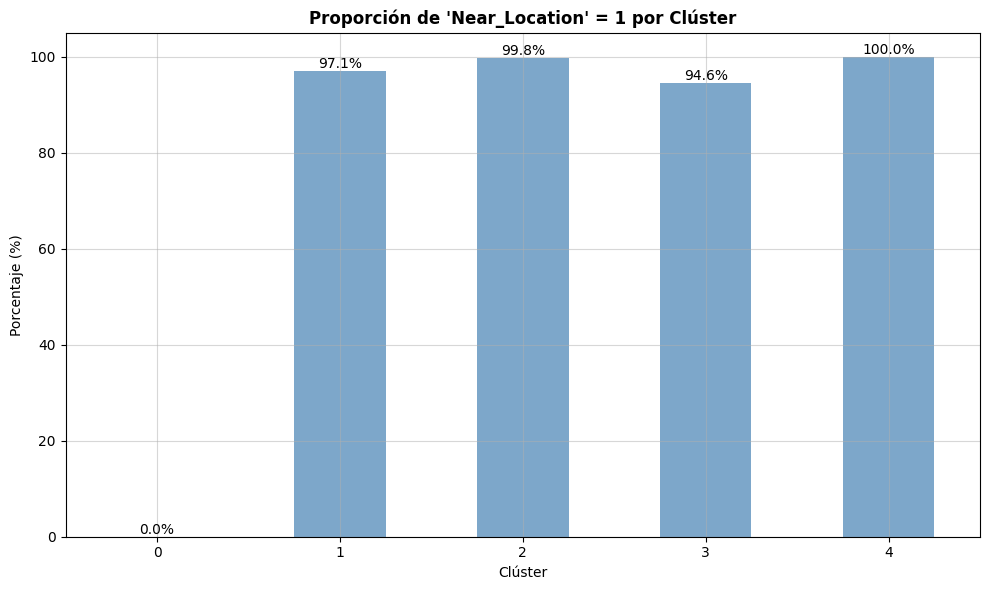

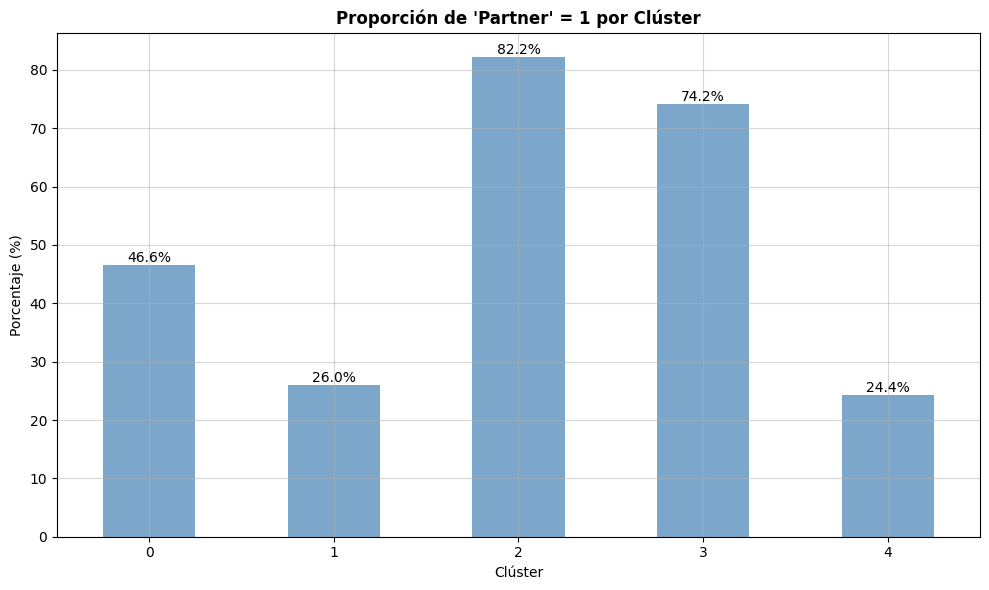

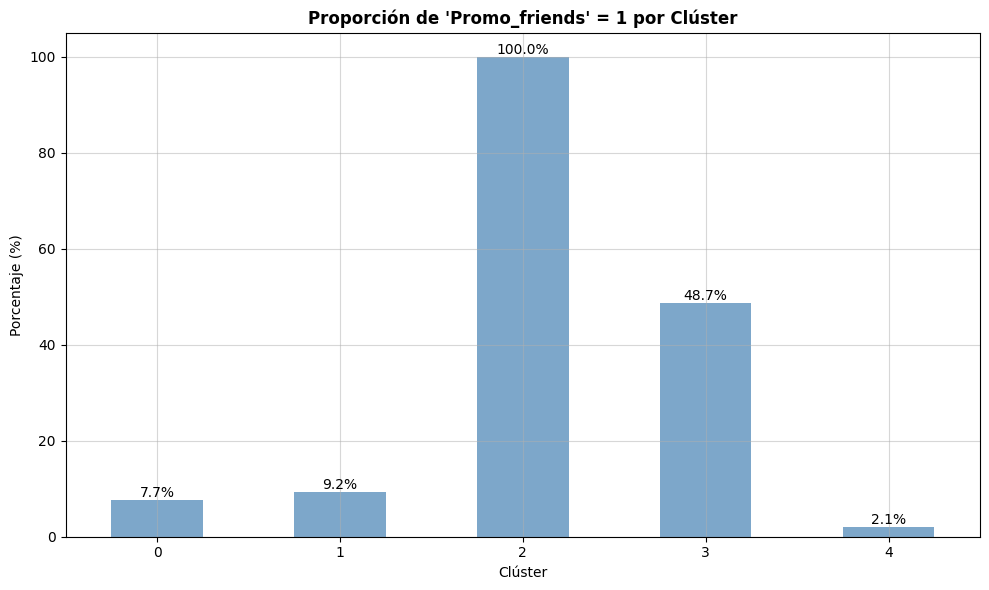

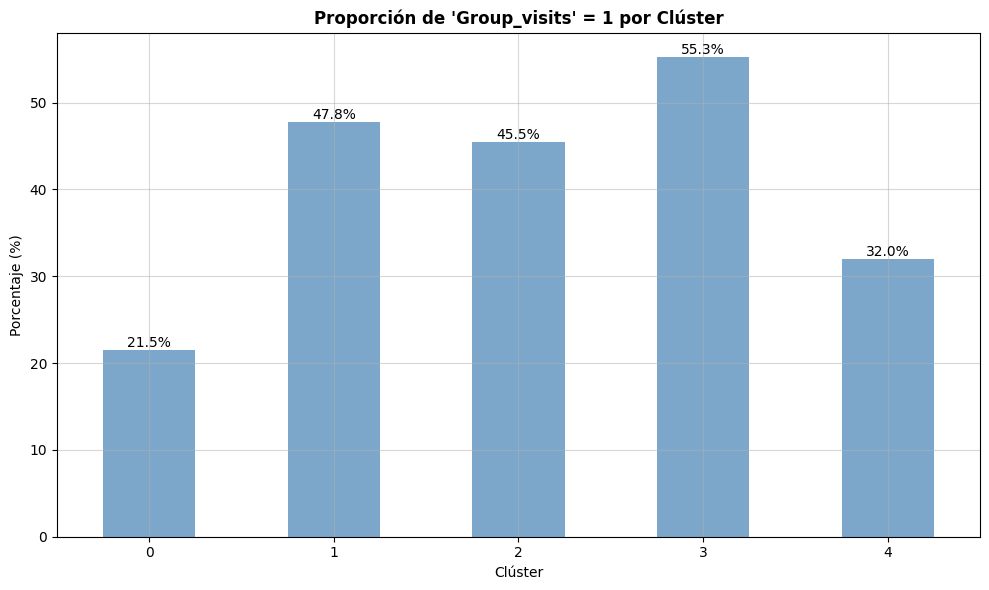

In [35]:
# Gráfico de barras para variables binarias
binary_vars = ['Near_Location', 'Partner', 'Promo_friends', 'Group_visits']

print("Variables Binarias - Proporciones por Clúster:")
for var in binary_vars:
    plt.figure(figsize=(10, 6))
    
    # Calcular proporción de 1s por clúster
    prop_by_cluster = gym_df_clustered.groupby('Cluster')[var].mean() * 100
    
    prop_by_cluster.plot(kind='bar', color='steelblue', alpha=0.7)
    plt.title(f"Proporción de '{var}' = 1 por Clúster", fontweight='bold')
    plt.ylabel('Porcentaje (%)')
    plt.xlabel("Clúster")
    plt.xticks(rotation=0)
    plt.grid(True, alpha=0.5)
    
    # Añadir valores en las barras
    for i, v in enumerate(prop_by_cluster):
        plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

**Observaciones:**

- Patrones marcados:
    - 'Near_Location':
        - Clúster 0 (95.9%), clúster 1 (86.2%) y clúster 4 (97.6%): Viven cerca. Son clientes locales comprometidos.
        - Clúster 2: 0% viven cerca. No son locales.
        - Clúster 3: 100% viven cerca. Clientes de alto riesgo debido al 'Churn'.
        - Vivir cerca NO garantiza la lealtad.
    <br>

    - 'Partner':
        - Clúster 0: 78.3% empleados asociados; empresas aliadas prácticamente.
        - Clúster 1, (47%) y clúster 2 (46.3%): Clientes mixtos.
        - Clúster 3 y clúster 4: ~35%, empleados asociados; clientes individuales.
        - Los empleados de empresas aliadas son más leales.
    <br>

    - 'Promo_friends':
        - Clúster 0: 57.4% van por recomendación. Red social fuerte.
        - Clústeres 1,3,4: ~23-31% van por recomendación. Menos conexión social.
        - Clúster 2: 7.9%, muy pocos referidos.
        - Los clientes referidos muestran mayor compromiso.
    <br>

    - 'Group_visits':
        - Clúster 0: 54.3% hacen clases grupales. Comunidad activa.
        - Clúster 1 (42.6%) y clúster 4 (47.4%):  Participación media.
        - Clúster 2: 21.6% de los clientes participan. Participación baja.
        - Clúster 3: 34.2% hacen clases grupales. Aislamiento relativo, participación media-baja.
        - La participación grupal está correlacionada con la lealtad.
    <br>

- Perfiles de clústeres: 
    - Clúster 0 (muy leales):
        - 96% viven cerca.
        - 78% empleados asociados.
        - 57% van por recomendación.
        - 54% hacen clases grupales.
        - Contratos largos y alta frecuencia.
    <br>

    - Clúster 1 (independientes):
        - 86% viven cerca
        - 47% empleados asociados (mixto)
        - 31% van por recomendación
        - 43% hacen clases grupales (participación media).
    <br>


    - Clúster 2 (no viven cerca):
        - 0% viven cerca (el único).
        - 46% empleados asociados (medio).
        - Solo 8% por recomendación (el más bajo).
        - Solo 22% clases grupales (el más bajo).
    <br>

    - Clúster 3 (alto riesgo):
        - 100% viven cerca (pero igual cancelan).
        - 35% empleados asociados.
        - Solo 24% por recomendación.
        - 34% hacen clases grupales.
    <br>

    - Clúster 4 (activos):
        - 98% viven cerca.
        - 36% empleados asociados.
        - 23% van por recomendación.
        - 47% hacen clases grupales (participación media-alta).
        - Mayor frecuencia (2.85 veces por semana).

### 4.6 Calcular tasa de cancelación para cada clúster.

In [36]:
# Calcular tasa de cancelación para cada clúster
churn_by_cluster = gym_df_clustered.groupby('Cluster')['Churn'].agg([
    ('total_clients', 'count'),
    ('churn_clients', 'sum'),
    ('churn_rate', 'mean')
]).round(4)

# Calcular porcentaje
churn_by_cluster['churn_rate_pct'] = (churn_by_cluster['churn_rate'] * 100).round(2)
churn_by_cluster['percentage_total'] = (churn_by_cluster['total_clients'] / len(gym_df_clustered) * 100).round(2)

print("'Churn' por clúster:")
display(churn_by_cluster)

'Churn' por clúster:


,total_clients,churn_clients,churn_rate,churn_rate_pct,percentage_total
Cluster,,,,,
0,545,245,0.4495,44.95,13.63
1,768,53,0.0690,6.90,19.20
2,642,159,0.2477,24.77,16.05
3,937,21,0.0224,2.24,23.42
4,1108,583,0.5262,52.62,27.70


In [37]:
    #Análisis de tasa de cancelación
    
    # Clasificar clústeres por nivel de riesgo
    print("Clústeres de riesgo alto ('Churn' > 30%):")
    high_risk = churn_by_cluster[churn_by_cluster['churn_rate_pct'] > 30]
    for cluster, row in high_risk.iterrows():
        print(f"   Clúster {cluster}: {row['churn_rate_pct']}% de 'Churn' ({row['churn_clients']}/{row['total_clients']} clients)")
    
    print("\nClústeres de riesgo medio ('Churn' 10-30%):")
    medium_risk = churn_by_cluster[(churn_by_cluster['churn_rate_pct'] >= 10) & (churn_by_cluster['churn_rate_pct'] <= 30)]
    for cluster, row in medium_risk.iterrows():
        print(f"   Clúster {cluster}: {row['churn_rate_pct']}% de 'Churn' ({row['churn_clients']}/{row['total_clients']} clients)")
    
    print("\nClústeres leales ('Churn' < 10%):")
    low_risk = churn_by_cluster[churn_by_cluster['churn_rate_pct'] < 10]
    for cluster, row in low_risk.iterrows():
        print(f"   Clúster {cluster}: {row['churn_rate_pct']}% de 'Churn' ({row['churn_clients']}/{row['total_clients']} clients)")

Clústeres de riesgo alto ('Churn' > 30%):
   Clúster 0: 44.95% de 'Churn' (245.0/545.0 clients)
   Clúster 4: 52.62% de 'Churn' (583.0/1108.0 clients)

Clústeres de riesgo medio ('Churn' 10-30%):
   Clúster 2: 24.77% de 'Churn' (159.0/642.0 clients)

Clústeres leales ('Churn' < 10%):
   Clúster 1: 6.9% de 'Churn' (53.0/768.0 clients)
   Clúster 3: 2.24% de 'Churn' (21.0/937.0 clients)


In [38]:
# Análisis comparativo
print("Análisis comparativo:")

# Diferencia entre mayor y menor 'Churn'
max_churn = churn_by_cluster['churn_rate_pct'].max()
min_churn = churn_by_cluster['churn_rate_pct'].min()
difference = max_churn - min_churn

print(f"\nDiferencia entre mayor y menor 'Churn': {difference:.2f}%")
print(f"   - Clúster con mayor 'Churn': {churn_by_cluster['churn_rate_pct'].idxmax()} ({max_churn}%)")
print(f"   - Clúster con menor 'Churn': {churn_by_cluster['churn_rate_pct'].idxmin()} ({min_churn}%)")

# Impacto en números absolutos
total_churn_clients = churn_by_cluster['churn_clients'].sum()
print(f"\nImpacto total del 'Churn': {total_churn_clients} clients perdidos")

# Clúster que más contribuye al 'Churn' total
cluster_contribution = churn_by_cluster['churn_clients'] / total_churn_clients * 100
max_contributor = cluster_contribution.idxmax()
print(f"\nClúster que más contribuye al 'Churn' total: {max_contributor} ({cluster_contribution[max_contributor]:.2f}% del total)")

Análisis comparativo:

Diferencia entre mayor y menor 'Churn': 50.38%
   - Clúster con mayor 'Churn': 4 (52.62%)
   - Clúster con menor 'Churn': 3 (2.24%)

Impacto total del 'Churn': 1061 clients perdidos

Clúster que más contribuye al 'Churn' total: 4 (54.95% del total)


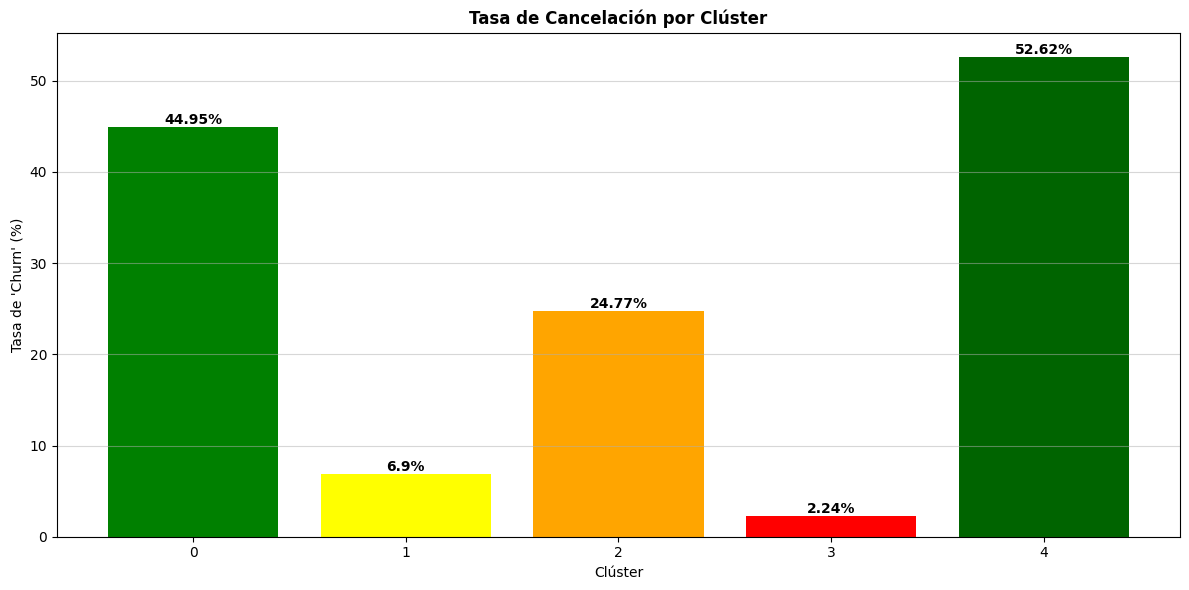

In [39]:
# Gráfica

plt.figure(figsize=(12, 6))
bars = plt.bar(churn_by_cluster.index, churn_by_cluster['churn_rate_pct'],
                color=['green', 'yellow', 'orange', 'red', 'darkgreen'])

plt.title('Tasa de Cancelación por Clúster', fontweight='bold')
plt.xlabel('Clúster')
plt.ylabel("Tasa de 'Churn' (%)")
plt.xticks(churn_by_cluster.index)

# Añadir valores en las barras
for bar, rate in zip(bars, churn_by_cluster['churn_rate_pct']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{rate}%', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.5, axis='y')
plt.tight_layout()
plt.show()

**¿Difieren en términos de tasa de cancelación?** 

Si, y de manera extrema:
- Existe un 48.66% de diferencia entre el mejor y peor clúster.
- Tasa del 2.77% en el mejor clúster, al 51.43% en el peor, de tasa de 'Churn'.

**¿Qué grupos son propensos a irse?**
- Clúster 3 (51.43%): "Nuevos y descomprometidos".
- Clúster 2 (44.36%): "Esforzados y desconectados".

**¿Cuáles son leales?**
- Clúster 0 (2.77%): "Comprometidos".
- Clúster 4 (6.80%): "Entusiastas activos"

## 5. Conclusiones y recomendaciones básicas:

**Conclusiones:**
- Segmentación clara:
    - Se identificaron 5 perfiles de clientes bien diferenciados con comportamientos distintivos.
    <br>
- Predictores clave:
    - `'Lifetime'`, `'Avg_class_frequency_current_month'` y `'Contract_period'` son los mejores y mayores predictores de `'Churn'`.
    <br>
- Foco crítico:
    - 2 clústeres (3 y 2) concentran el 76% del problema de cancelación.
    <br>
- Oportunidad identificada:
    - Los patrones de comportamiento permiten intervenciones preventivas efectivas.
    <br>
- Modelo efectivo:
    - La regresión logística predice `'Churn'` con 92% de exactitud, 88% de precisión y 83% de recall.

**Principios escenciales para la retención:**
1. Enfoque en el primer trimestre:
    - Los clientes nuevos (<3 meses) son los más vulnerables.
2. Compromiso progresivo:  
    - Contratos más largos y actividades grupales aumentan significativamente la lealtad.
3. Conexión multicanal: 
    - Combinar contacto telefónico con mayor integración presencial y digital.
4. Segmentación accionable:
    - Estrategias específicas para cada perfil identificado en el clustering.

**Recomendaciones:**
- Clúster 3: "Nuevos y descomprometidos" (51.4% `'Churn'`):
    - Programa de "onboarding" intensivo los primeros 60 días.
    - Oferta de una mejora de contrato de 3 meses con 20% descuento.
    - Invitaciones especiales a 3 clases grupales introductorias.
    - Asignar un entrenador personal por los primeros 30 días.
    <br>
- Clúster 2: "Esforzados pero desconectados" (44.4% `'Churn'`):
    - Programa de fidelización por distancia (puntos por cada km recorrido).
    - Paquetes de 6 u 8 visitas mensuales con precio preferencial.
    - Crear una comunidad virtual para establecer mayor conexión entre miembros.
    - Realizar pequeños eventos presenciales para fomentar una mayor conexión.
    - Servicio de transporte compartido un día a la semana (viernes o sábados).
    <br>
- Clúster 1: "Independientes" (26.8% `'Churn'`):
    - Estrategias de contacto por email y app móvil, con canal preferente.
    - Programa de autogestión con recordatorios automáticos.
    - Beneficios por participación en encuestas online.
    <br>
- Clústeres 0 y 4 - "Leales" (<7% `'Churn'`):
    - Programa de referidos premium ($50 por amigo que se una).
    - Acceso prioritario a nuevas clases y equipos.
    - Reconocimiento como miembros con beneficios exclusivos.
    - Encuestas de mejora continua con incentivos.

**Posible impacto esperado:**
- Reducción del 15-20% en tasa general de `'Churn'`.
- Incremento de ~15% en retención de clientes nuevos.
- Mejora de ~20% en participación en actividades grupales.
- Aumento de ~10% en mejoras de contratos a largo plazo.
- Optimización de ~30% en recursos de marketing dirigidos.